In [2]:
import os
import shutil
import zipfile
import cv2
import numpy as np
import torch
import time
from torch import nn
import random
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import matplotlib.pyplot as plt
import torch.nn.functional as F
from scipy.ndimage import distance_transform_bf
from torchvision.transforms.functional import center_crop
torch.set_grad_enabled(True)

In [3]:
#extract files.zip
with zipfile.ZipFile('/content/drive/My Drive/orig_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
shutil.rmtree('resized_dataset')

FileNotFoundError: [Errno 2] No such file or directory: 'resized_dataset'

In [5]:
def get_random_click(ground_truth, prediction):
    #prediction = prediction.astype(bool)
    #ground_truth = ground_truth.astype(bool)

    #prediction = prediction.astype(int)
    #gt = ground_truth.astype(int)

    #prediction = np.array(prediction)
    #ground_truth = np.array(ground_truth)

    prediction = prediction.astype(int)
    gt = ground_truth.astype(int)
    D_map = gt - prediction

    D_plus = D_map.copy()
    D_minus = D_map.copy()
    D_plus[D_plus < 0] = 0 #D_plus are false-negative pixels
    D_minus[D_minus > 0] = 0 #D_minus are false-positive pixels
    D_minus = np.abs(D_minus)

    #sum non zero elements of D_minus and D_plus
    sum_D_minus = np.sum(D_minus)
    sum_D_plus = np.sum(D_plus)


    click_type = False
    if(sum_D_minus > sum_D_plus):
        click_type = False
        selected_map = D_minus
    else:
        click_type = True
        selected_map = D_plus

    #get distances of each pixel to the nearest border
    selected_map = selected_map.astype(np.uint8)
    sel_map_transformed = cv2.distanceTransform(selected_map, cv2.DIST_L2, 5)

    #make the distances even more significant
    #this is disabled due to overflows, couldnt really fix it
    #sel_map_exp = np.expm1(sel_map_transformed)

    # -----------------------------------------------------
    #this should only happen on perfect prediction
    if(np.sum(sel_map_transformed) == 0):
        return (-1, -1), click_type

    #get probability map and flattened probablities for pixel selection
    P_map = sel_map_transformed / (np.sum(sel_map_transformed))
    flattened_probabilities = P_map.flatten()
    # -----------------------------------------------------------



    #select a random pixel based on the probabilities
    random_pixel_index = np.random.choice(np.arange(len(flattened_probabilities)), p=flattened_probabilities)
    random_pixel_2d_index = np.unravel_index(random_pixel_index, P_map.shape)
    return random_pixel_2d_index, click_type

Convolutional block which combines 2D convolution, batch normalization and ReLU activation into one.

In [6]:
class CNNBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.seq_block(x)
        return x

Block of N convolutional blocks (N = 3 for basic UNET)

In [7]:
class CNNBlocks(nn.Module):
    def __init__(self,
                 n_conv,
                 in_channels,
                 out_channels,
                 padding):
        super(CNNBlocks, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(n_conv):
            self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
            # after each convolution we set (next) in_channel to (previous) out_channels
            in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

Encoder part of the UNET.

In [8]:
class Encoder(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 padding,
                 downhill=4): #amount of steps in Encoder
        super(Encoder, self).__init__()
        self.enc_layers = nn.ModuleList()

        #add a cnn block and a max pool layer for each step
        for _ in range(downhill):
            self.enc_layers += [
                    CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                    nn.MaxPool2d(2, 2)
                ]
            in_channels = out_channels #set the amount of input channels of the next step as the output of this step
            out_channels *= 2 #double the amount of output channels for the next step

        #depth of the last CNN block is doubled (bottleneck)
        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels,
                                         out_channels=out_channels, padding=padding))

    def forward(self, x):
        route_connection = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                route_connection.append(x) #appending connections (horizontal arrows in UNET architecture)
            else:
                x = layer(x)
        return x, route_connection

Decoder part of the UNET

In [9]:
class Decoder(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 exit_channels,
                 padding,
                 uphill=4):
        super(Decoder, self).__init__()
        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(uphill):
            self.layers += [
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                CNNBlocks(n_conv=2, in_channels=in_channels,
                          out_channels=out_channels, padding=padding),
            ]
            #halving input and output channels on each step upwards
            in_channels //= 2
            out_channels //= 2

        #one more convolution ath the end with kernel size 1
        self.layers.append(
            nn.Conv2d(in_channels, exit_channels, kernel_size=1, padding=padding),
        )

        #sigmoid output to turn logits into probabilities of pixels belonging to the final mask
        self.layers.append(nn.Sigmoid())


    def forward(self, x, routes_connection):
        #pop the last route connection (this one was created for bottleneck and is useless)
        routes_connection.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                #crop to make input and output dimensions match
                routes_connection[-1] = center_crop(routes_connection[-1], x.shape[2])
                #use concatenation for connections
                x = torch.cat([x, routes_connection.pop(-1)], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

UNET model class

In [10]:
class UNET(nn.Module):
    def __init__(self,
                 in_channels,
                 first_out_channels, #output of the first CNN Block
                 exit_channels,
                 downhill,
                 padding=1
                 ):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, downhill=downhill)
        self.decoder = Decoder(first_out_channels*(2**downhill), first_out_channels*(2**(downhill-1)),
                               exit_channels, padding=padding, uphill=downhill)

    def forward(self, x):
        enc_out, routes = self.encoder(x)
        out = self.decoder(enc_out, routes)
        return out

Class for loading an image dataset

In [11]:
class CustomImageDataset(Dataset):
    def __init__(self, dataset_dir, mode, transform=None, target_transform=None, total_cnt=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_data = [] #will store tuples of paths to image and label
        for imgnum_dir in os.listdir(dataset_dir + "/" + mode + "/"):
            img_dir = dataset_dir + "/" + mode + "/" + imgnum_dir + "/img"
            label_dir = dataset_dir + "/" + mode + "/" + imgnum_dir + "/label"
            for img in os.listdir(img_dir):
                for label in os.listdir(label_dir):
                    if label.startswith(img.split(".")[0]):
                        self.image_data.append((os.path.join(img_dir, img), os.path.join(label_dir, label)))
        #shuffle training data
        random.shuffle(self.image_data)
        if(total_cnt != None):
            self.image_data = self.image_data[:total_cnt]


    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_data[idx][0])
        label_path = os.path.join(self.image_data[idx][1])

        image = read_image(img_path)
        label = read_image(label_path)

        image = image.numpy()
        label = label.numpy()

        image = np.transpose(image, (1, 2, 0))
        label = np.transpose(label, (1, 2, 0))

        #normalize from 0-255 to 0-1 float range
        image = (image - np.min(image)) / (np.max(image) - np.min(image))
        label = (label - np.min(label)) / (np.max(label) - np.min(label))

        #insert first positive click
        random_pixel_2d_index, click_type = get_random_click(label, np.zeros(label.shape))
        pos_click_map = np.zeros(label.shape)
        pos_click_map[random_pixel_2d_index] = 1
        pos_click_map = gauss_filter(pos_click_map, 2)
        pos_click_map = (pos_click_map - np.min(pos_click_map)) / (np.max(pos_click_map) - np.min(pos_click_map))
        neg_click_map = np.zeros(label.shape)

        #add dimension to pos_click_map
        pos_click_map = np.expand_dims(pos_click_map, axis=2)
        #concatenate channels
        image = np.concatenate((image, pos_click_map, neg_click_map), axis=2)

        return image, label

In [12]:
def gauss_filter(image, sigma):
    return cv2.GaussianBlur(image, (0, 0), sigma)

In [22]:
train_dataset = CustomImageDataset("dataset", "training", transform=transforms.ToTensor(), total_cnt=7000)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset = CustomImageDataset("dataset", "testing", transform=transforms.ToTensor(), total_cnt=1000)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)
print(len(train_dataloader))
print(len(val_dataloader))

438
63


In [14]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceloss, self).init()
    def forward(self,pred, label):
       smooth = 1
       iflat = pred.contiguous().view(-1)
       tflat = label.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))

In [15]:
def add_clicks_to_batch(input, pred, label, k, total_k, probabilistic_clicks=False):
    click_probability = 1.0
    if probabilistic_clicks:
        click_probability = 1.0 - (float(k) / float(total_k))
    #for each image in batch
    pred = pred.permute(0, 2, 3, 1)
    label = label.permute(0, 2, 3, 1)
    for i in range(pred.shape[0]):
        #get random click
        if np.random.rand() > click_probability:
            continue
        #convert from tensor to numpy array (detaching is safe, we do not need gradients in this stage)
        pred_np = pred[i].detach().cpu().numpy()
        label_np = label[i].detach().cpu().numpy()
        #turn pred and label from (W,H,1) to (W,H)
        pred_np = pred_np[:,:,0]
        label_np = label_np[:,:,0]
        random_pixel_2d_index, click_type = get_random_click(label_np, pred_np)
        #nowhere to place click
        if(random_pixel_2d_index == (-1,-1)):
            continue
        pos_map = np.zeros(pred_np.shape)
        neg_map = np.zeros(pred_np.shape)
        if click_type:
            pos_map[random_pixel_2d_index] = 1
            pos_map = gauss_filter(pos_map, 2)
            pos_map = (pos_map - np.min(pos_map)) / (np.max(pos_map) - np.min(pos_map))
        else:
            neg_map[random_pixel_2d_index] = 1
            neg_map = gauss_filter(neg_map, 2)
            neg_map = (neg_map - np.min(neg_map)) / (np.max(neg_map) - np.min(neg_map))

        #get the second channel of the input image
        input_pos_map = input[i][1].detach().cpu().numpy()
        input_neg_map = input[i][2].detach().cpu().numpy()

        #add the input maps and new click maps
        input_pos_map = input_pos_map + pos_map
        input_neg_map = input_neg_map + neg_map

        #normalize the input maps
        input_pos_map = (input_pos_map - np.min(input_pos_map)) / ((np.max(input_pos_map) - np.min(input_pos_map)) + 0.0000001) #small epsilon to avoi NaNs
        input_neg_map = (input_neg_map - np.min(input_neg_map)) / ((np.max(input_neg_map) - np.min(input_neg_map)) + 0.0000001)

        #add the new maps to the input
        input[i][1] = torch.tensor(input_pos_map)
        input[i][2] = torch.tensor(input_neg_map)
    return input

In [16]:
def get_iou(pred, label):
    pred = pred.detach().cpu().numpy()
    label = label.detach().cpu().numpy()
    intersection = np.logical_and(pred, label)
    union = np.logical_or(pred, label)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [17]:
def train(dataloader, model, loss_fn, optimizer, device, k):
    size = len(dataloader)
    avg_loss = 0
    avg_iou = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = X.permute(0, 3, 1, 2)
        y = y.permute(0, 3, 1, 2)
        X = X.float()
        #prediction part
        for i in range(k):
            print(X.shape)
            '''plt.figure(figsize=(10,10))
            for j in range(16):
                #if X[i] is out of range, break
                if j >= X.shape[0]:
                    break
                print_img = X[j].permute(1,2,0)
                print_img = print_img.clone().detach().cpu().numpy()
                plt.subplot(4,4,j+1)
                plt.axis('off')
                #make images as close to each other as possible
                plt.subplots_adjust(wspace=0, hspace=0)
                plt.imshow(print_img)
            plt.show()'''


            pred = model(X)
            pred = center_crop(pred, y.shape[2])
            pred = pred > 0.5
            X = add_clicks_to_batch(X, pred, y, i, k, True)

            '''plt.figure(figsize=(10,10))
            for j in range(16):
                #if pred is out of range, break
                if j >= pred.shape[0]:
                    break
                print_pred = pred[j].permute(1,2,0)
                print_pred = print_pred.clone().detach().cpu().numpy()
                plt.subplot(4,4,j+1)
                plt.axis('off')
                #make images as close to each other as possible
                plt.subplots_adjust(wspace=0, hspace=0)
                plt.imshow(print_pred)
            plt.show()'''
        #training part
        # plt.figure(figsize=(10,10))
        # for i in range(16):
        #     #if X[i] is out of range, break
        #     if i >= X.shape[0]:
        #         break
        #     print_img = X[i].permute(1,2,0)
        #     print_img = print_img.clone().detach().cpu().numpy()
        #     plt.subplot(4,4,i+1)
        #     plt.axis('off')
        #     #make images as close to each other as possible
        #     plt.subplots_adjust(wspace=0, hspace=0)
        #     plt.imshow(print_img)
        # plt.show()


        pred = model(X)
        pred = center_crop(pred, y.shape[2])
        pred = pred.float()

        #print all 16 predictions in 4x4 grid
        # plt.figure(figsize=(10,10))
        # plt.tight_layout()
        # for i in range(16):
        #     #if pred is out of range, break
        #     if i >= pred.shape[0]:
        #         break
        #     print_pred = pred[i].permute(1,2,0)
        #     print_pred = print_pred.clone().detach().cpu().numpy()
        #     plt.subplot(4,4,i+1)
        #     plt.axis('off')
        #     #make images as close to each other as possible
        #     plt.subplots_adjust(wspace=0, hspace=0)
        #     plt.imshow(print_pred)
        # plt.show()

        y = y > 0.5
        y = y.float()
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        avg_loss += loss.item()
        #print all 16 predictions in 4x4 grid
        '''plt.figure(figsize=(10,10))
        plt.tight_layout()
        for i in range(16):
            #if pred is out of range, break
            if i >= pred.shape[0]:
                break
            print_pred = pred[i].permute(1,2,0)
            print_pred = print_pred.clone().detach().cpu().numpy()
            #print_pred = (print_pred - np.min(print_pred)) / (np.max(print_pred) - np.min(print_pred))
            print_pred = print_pred > 0.5
            plt.subplot(4,4,i+1)
            plt.axis('off')
            #make images as close to each other as possible
            plt.subplots_adjust(wspace=0, hspace=0)
            plt.imshow(print_pred)
        plt.show()'''
        pred = pred > 0.5
        avg_iou += get_iou(pred, y)
        print(loss.item())
    avg_iou = avg_iou/size
    avg_loss = avg_loss/size
    return avg_loss, avg_iou

In [18]:
def eval(dataloader, model, loss_fn, device, k):
    size = len(dataloader)
    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.permute(0, 3, 1, 2)
            y = y.permute(0, 3, 1, 2)
            X = X.float()
            y = y > 0.5
            y = y.float()
            for i in range(k):
                pred = model(X)
                pred = center_crop(pred, y.shape[2])
                pred = pred > 0.5
                X = add_clicks_to_batch(X, pred, y, i, k, False)
            pred = model(X)
            pred = center_crop(pred, y.shape[2])
            loss = loss_fn(pred, y)
            avg_loss += loss.item()
            pred = pred > 0.5
            avg_iou += get_iou(pred, y)
    avg_loss = avg_loss/size
    avg_iou = avg_iou/size
    return avg_loss, avg_iou

In [23]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model = UNET(in_channels=3, first_out_channels=32, exit_channels=1, downhill=4)

model.to(device)
#print(model)

loss_fn = diceloss()
#loss_fn = nn.BCEWithLogitsLoss()
lr = 0.004
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 18

train_loss_record = []
train_iou_record = []
val_loss_record = []
val_iou_record = []
for i in range(epochs):
    print("Epoch: " + str(i))
    model.train()
    #linearly decrease learning rate
    #optimizer.param_groups[0]['lr'] = lr - ((i * (lr / epochs))*1)
    optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] * 0.9
    print("Learning rate: " + str(optimizer.param_groups[0]['lr']))
    train_loss, train_iou = train(train_dataloader, model, loss_fn, optimizer, device, 15)
    print(train_loss, train_iou)
    train_loss_record.append(train_loss)
    train_iou_record.append(train_iou)
    model.eval()
    val_loss, val_iou = eval(val_dataloader, model, loss_fn, device, 15)
    val_loss_record.append(val_loss)
    val_iou_record.append(val_iou)
    print(val_loss, val_iou)


torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f="./InterSegModelV1.pth")


Streaming output truncated to the last 5000 lines.
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
0.038649141788482666
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
0.022117137908935547
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 3, 512, 512])
torch.S

Text(0.5, 1.0, 'IoU')

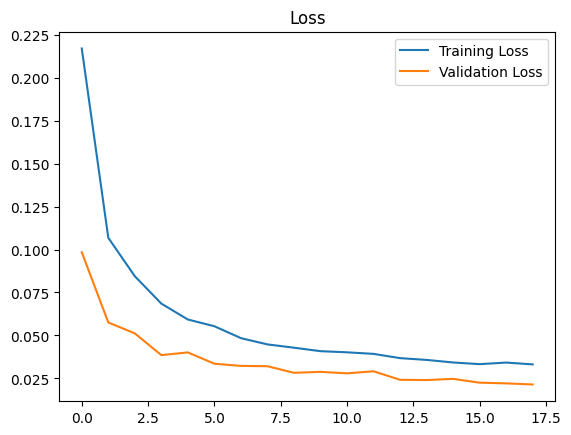

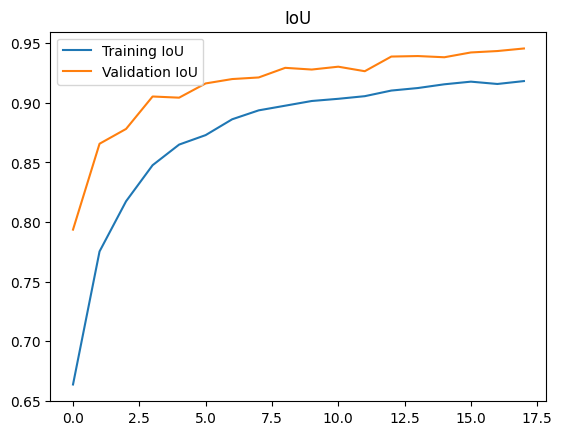

In [24]:
#into ope plot display loss of training and validation
plt.figure()
plt.plot(train_loss_record, label="Training Loss")
plt.plot(val_loss_record, label="Validation Loss")
plt.legend()
plt.title("Loss")

plt.figure()
plt.plot(train_iou_record, label="Training IoU")
plt.plot(val_iou_record, label="Validation IoU")
plt.legend()
plt.title("IoU")

In [25]:
def visual_eval(dataloader, model, device, k):
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = X.permute(0, 3, 1, 2)
            y = y.permute(0, 3, 1, 2)
            X = X.float()
            y = y > 0.5
            y = y.float()
            for i in range(k):
                pred = model(X)
                pred = center_crop(pred, y.shape[2])
                pred = pred > 0.5
                X = add_clicks_to_batch(X, pred, y, i, k, False)
            pred = model(X)
            pred = center_crop(pred, y.shape[2])
            pred = pred > 0.5
            plt.figure(figsize=(10,10))
            for i in range(16):
                #if pred is out of range, break
                if i >= pred.shape[0]:
                    break
                #print image, prediction and ground truth in one picture
                print_img = X[i].permute(1,2,0)
                print_img = print_img.clone().detach().cpu().numpy()
                print_pred = pred[i].permute(1,2,0)
                print_pred = print_pred.clone().detach().cpu().numpy()
                print_gt = y[i].permute(1,2,0)
                print_gt = print_gt.clone().detach().cpu().numpy()
                plt.subplot(4,4,i+1)
                plt.axis('off')
                #make images as close to each other as possible
                plt.subplots_adjust(wspace=0, hspace=0)
                #plt.imshow(print_img)
                plt.imshow(print_pred)
                plt.imshow(print_gt, alpha=0.2, cmap="Blues")
            plt.show()
            avg_iou = get_iou(pred, y)
            print(avg_iou)

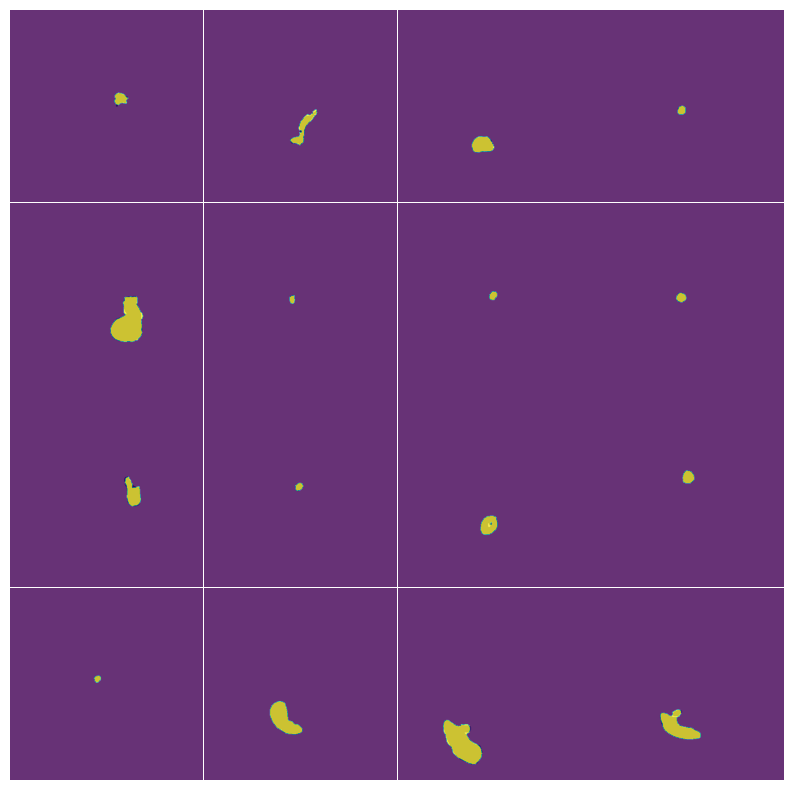

0.9294277771342523


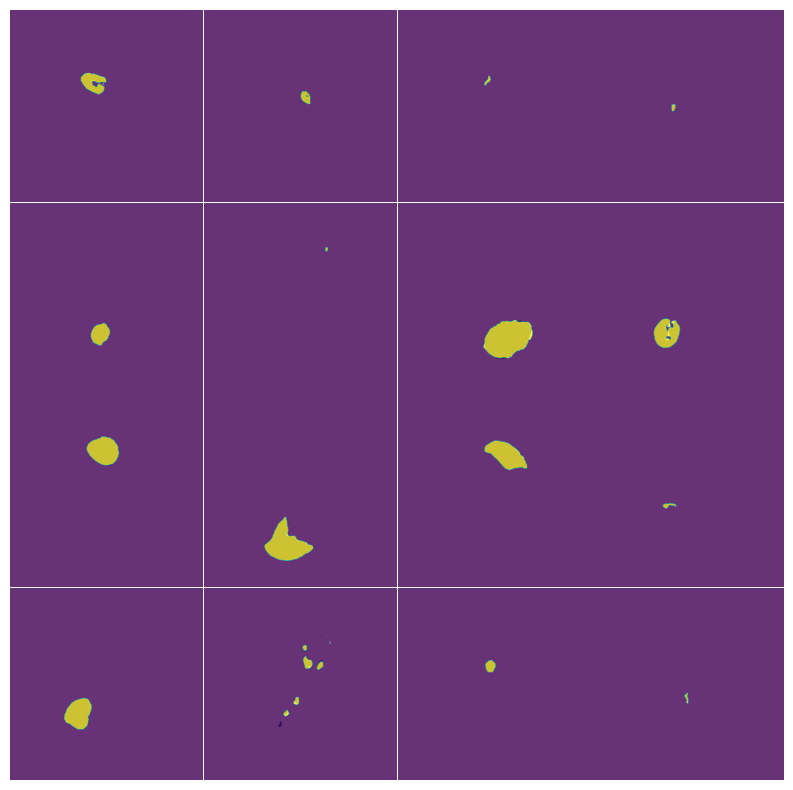

0.9450397901971423


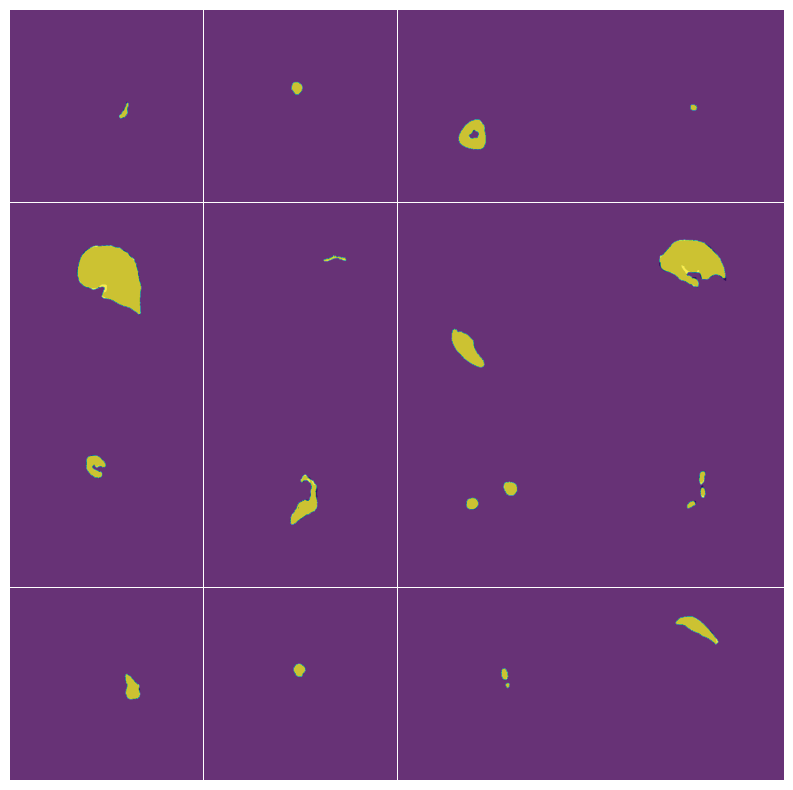

0.9424144889348431


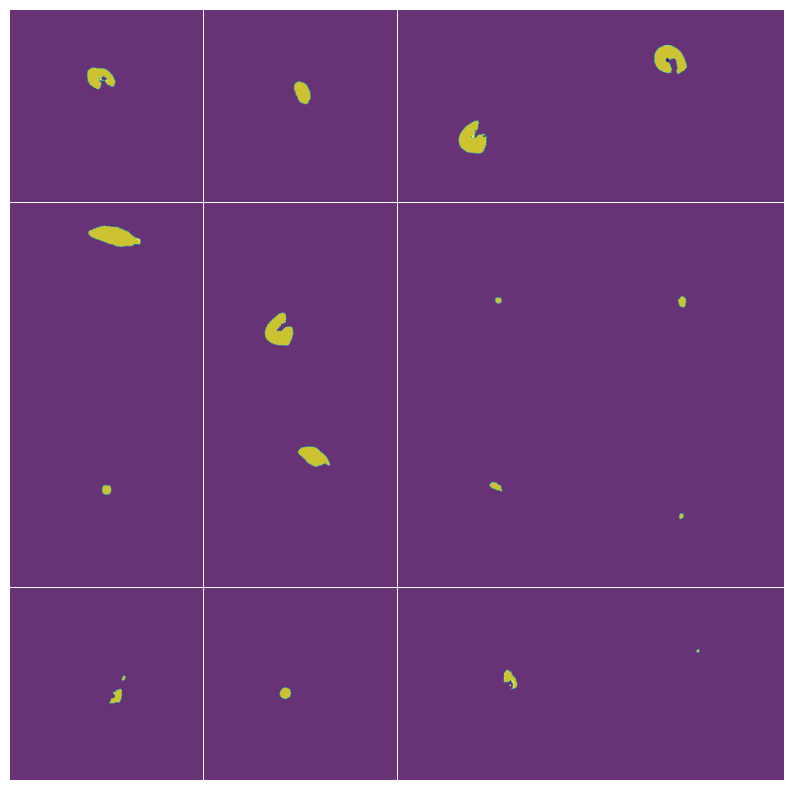

0.9427302631578948


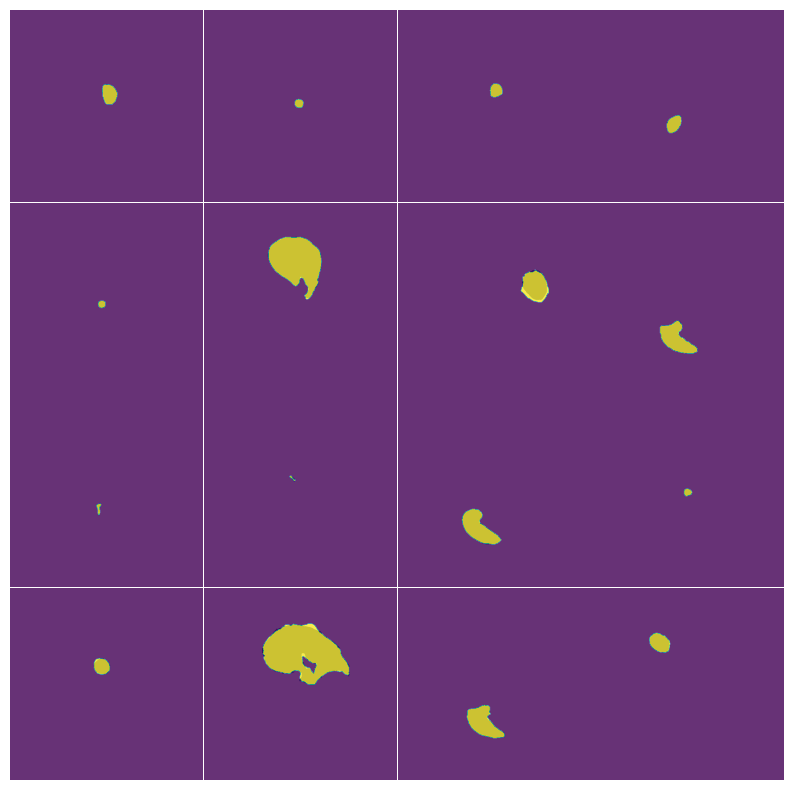

0.9495077376785475


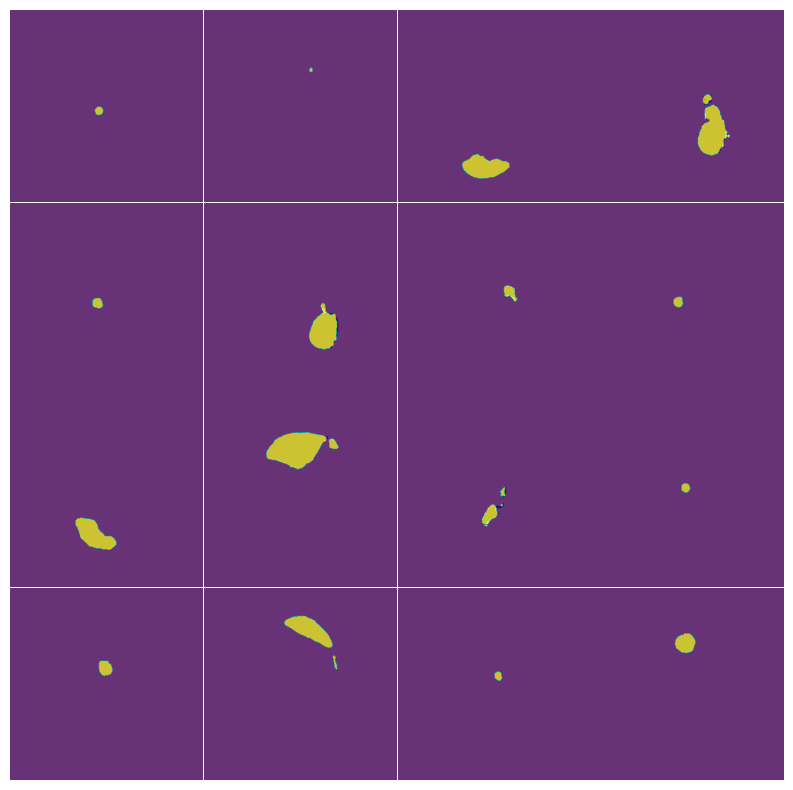

0.9449382963780476


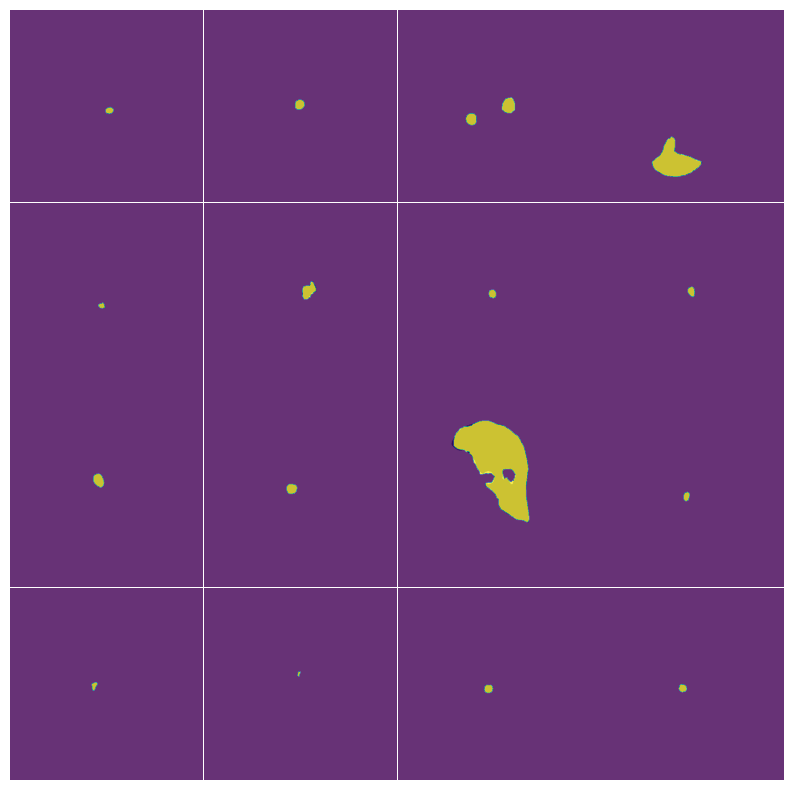

0.9622903123153157


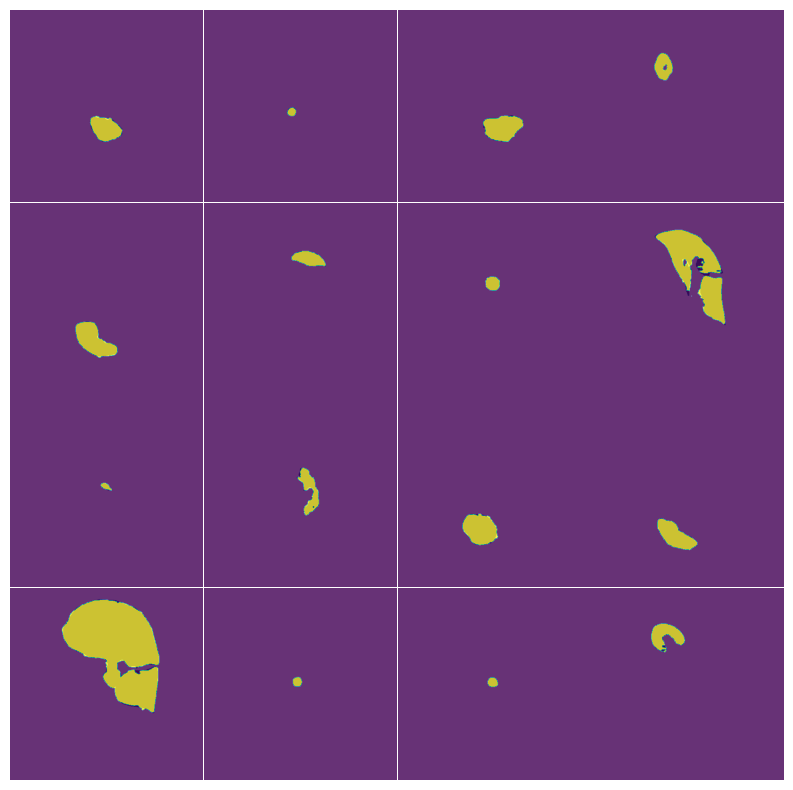

0.9513282952385368


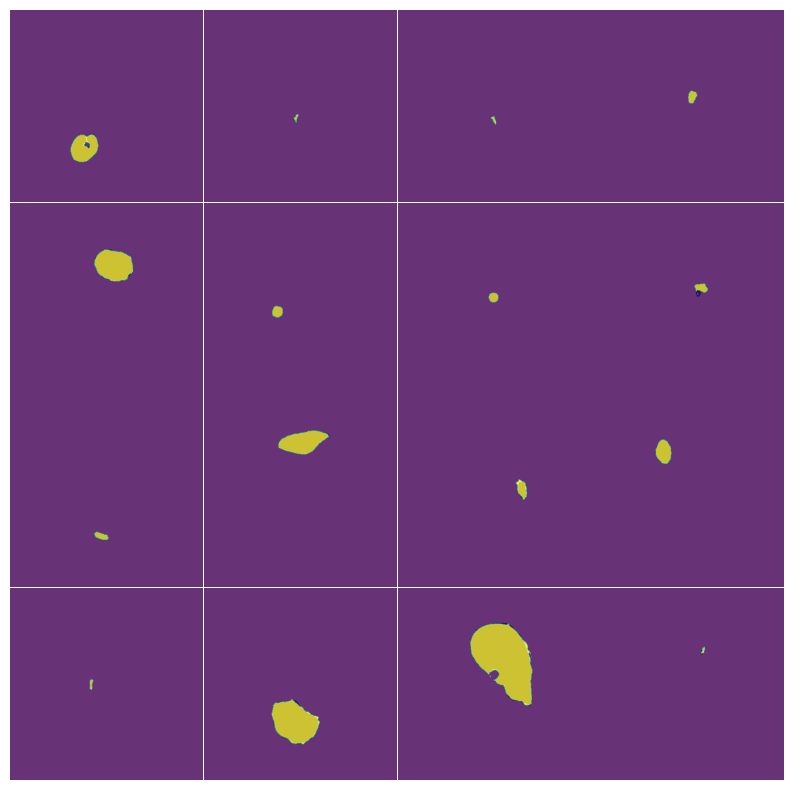

0.9523993062247061


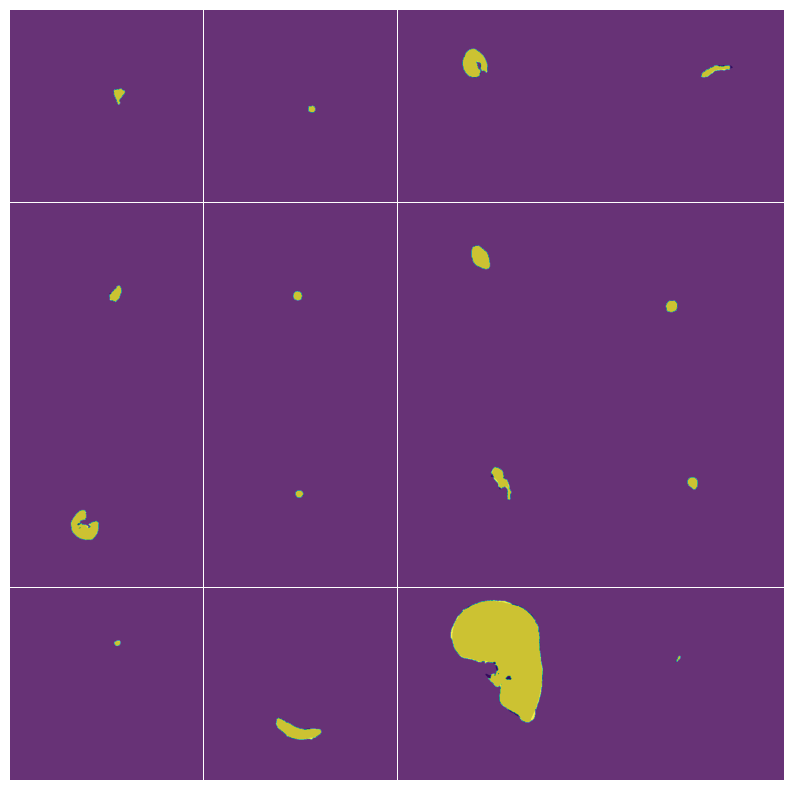

0.9563725984751308


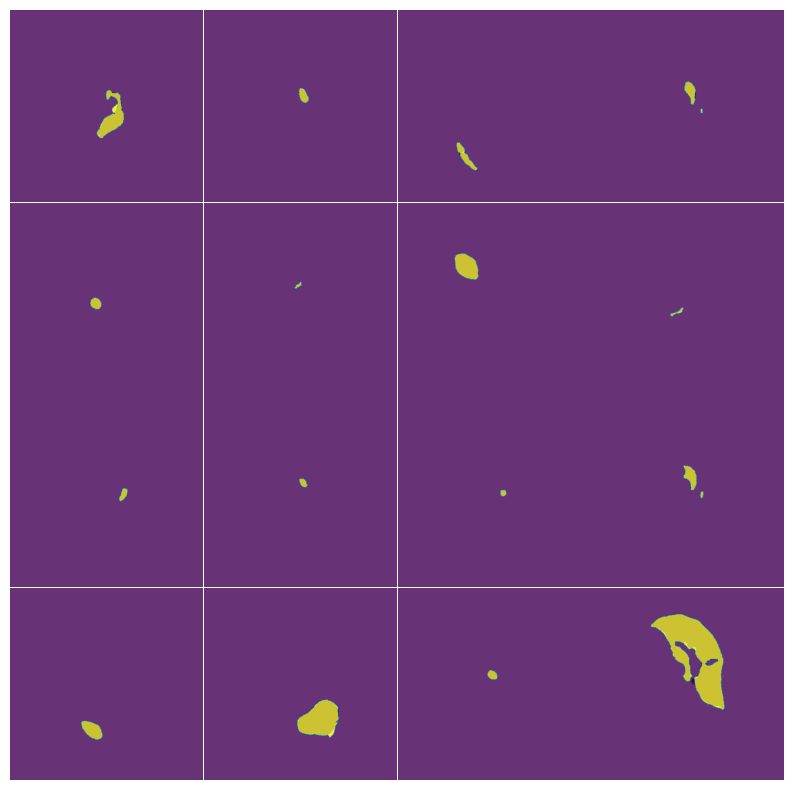

0.9402724113368014


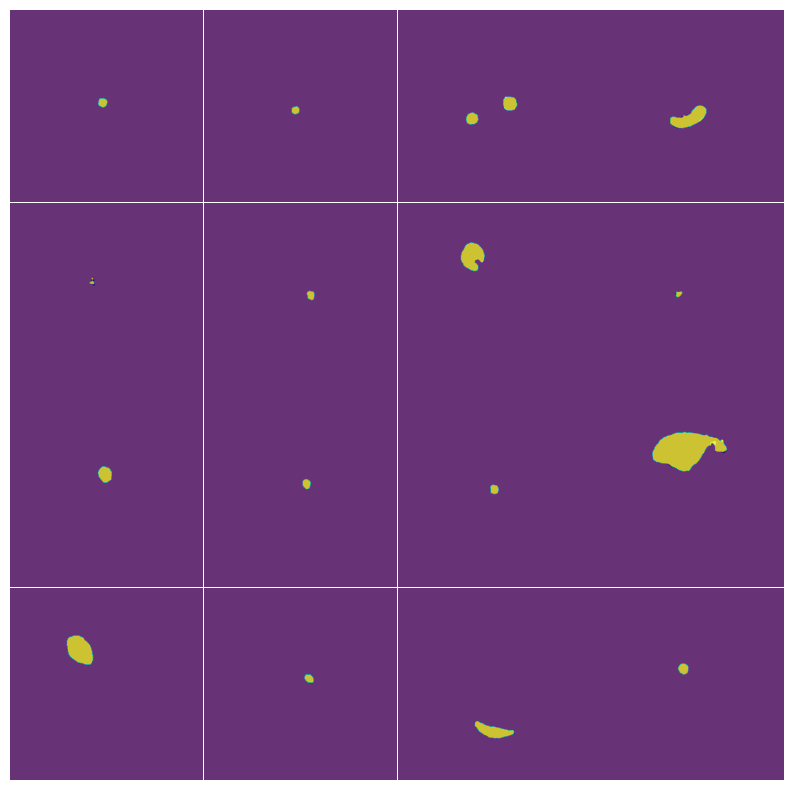

0.9545102173710813


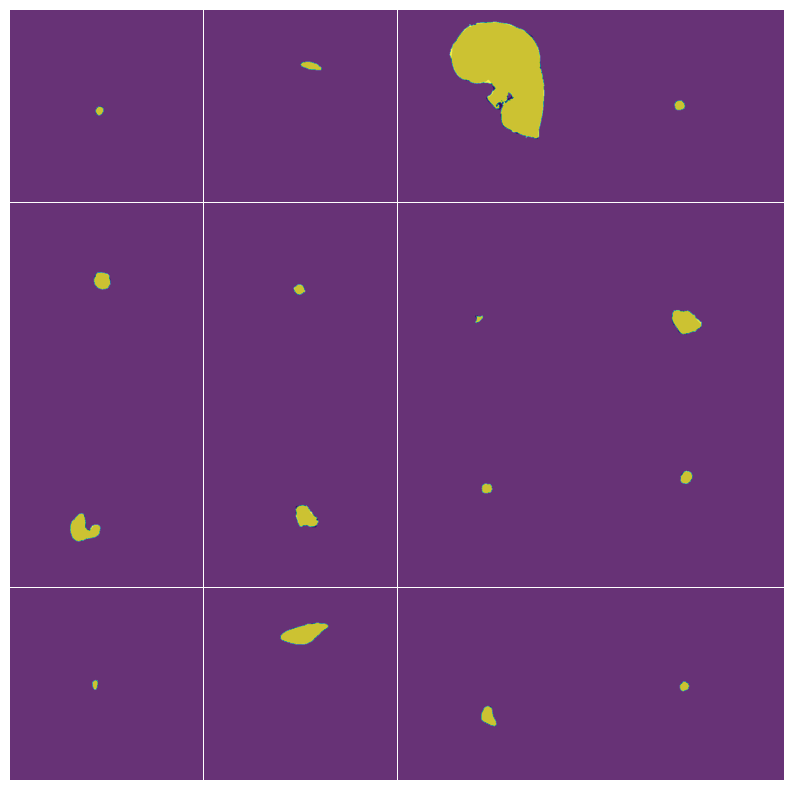

0.9600100288328945


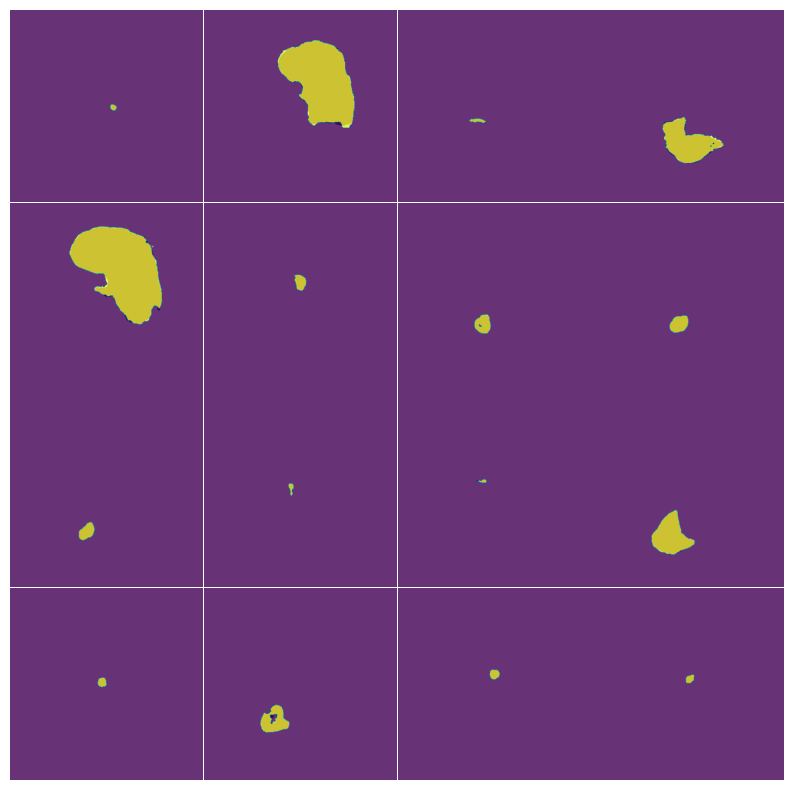

0.9642580183333002


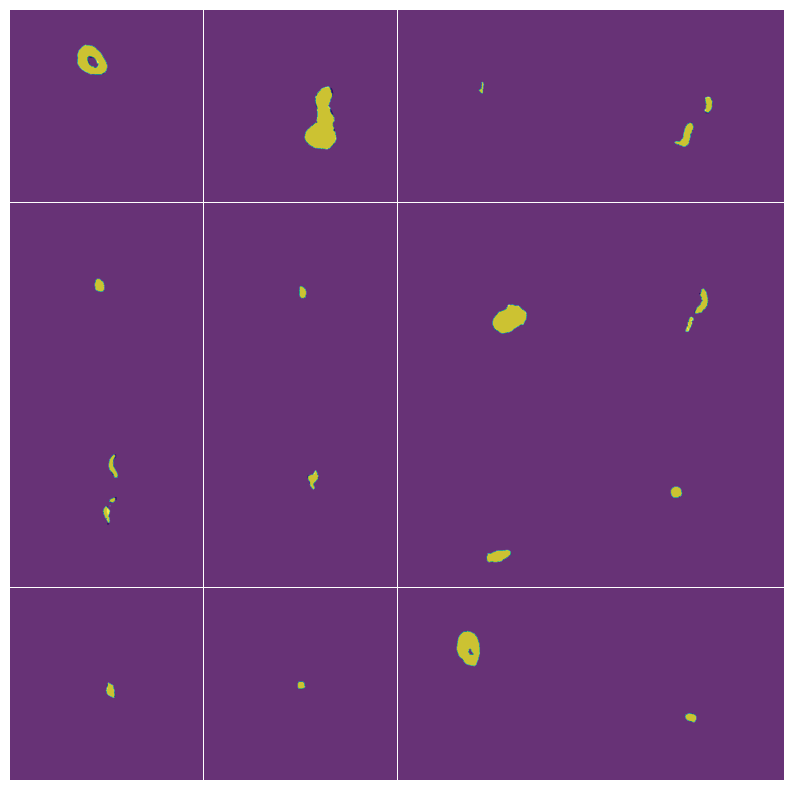

0.9270326192794547


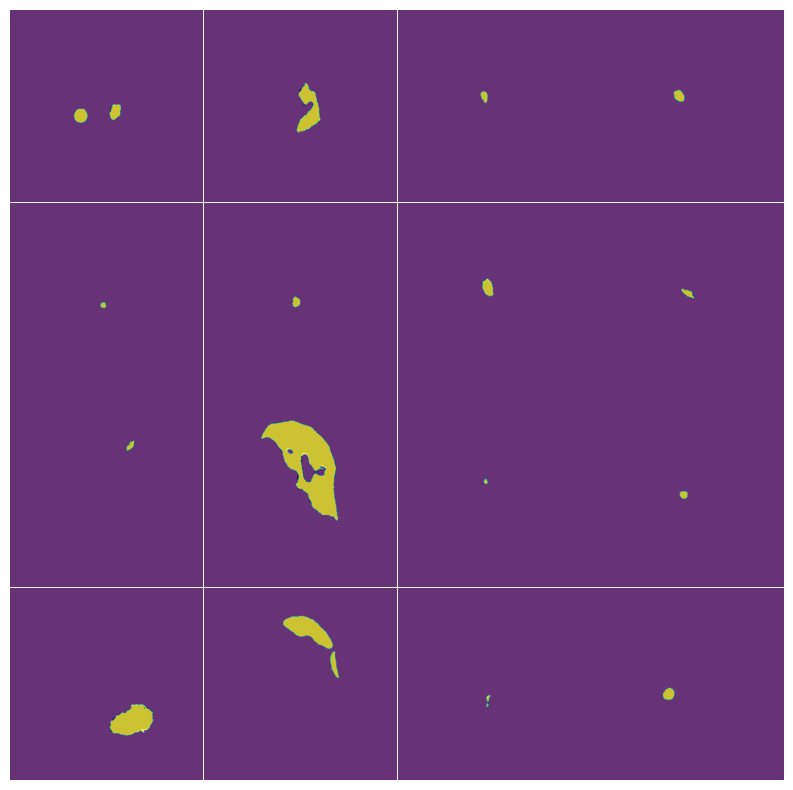

0.9474643991394325


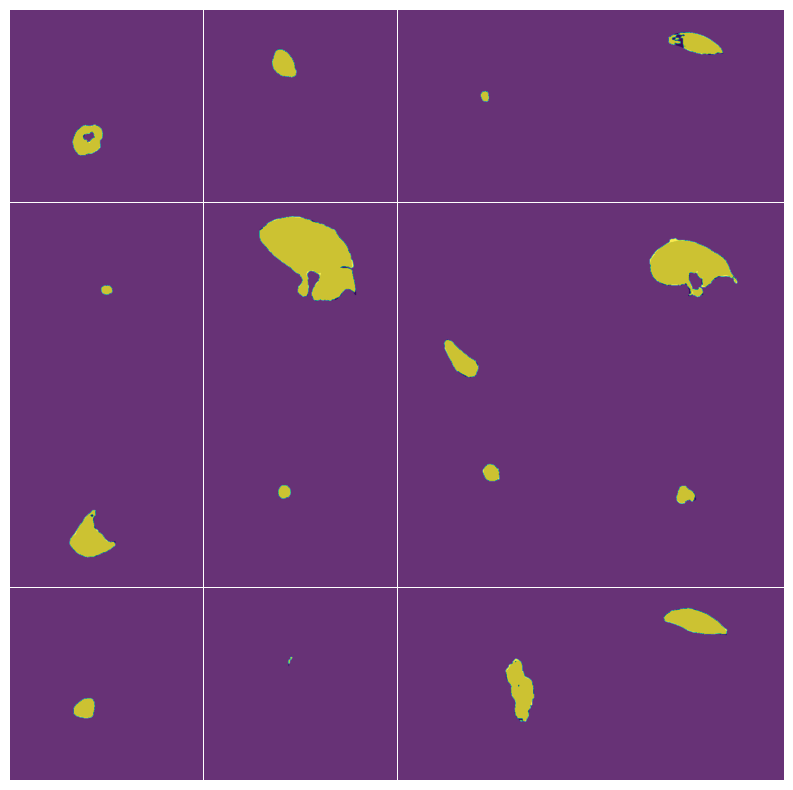

0.9515246135461239


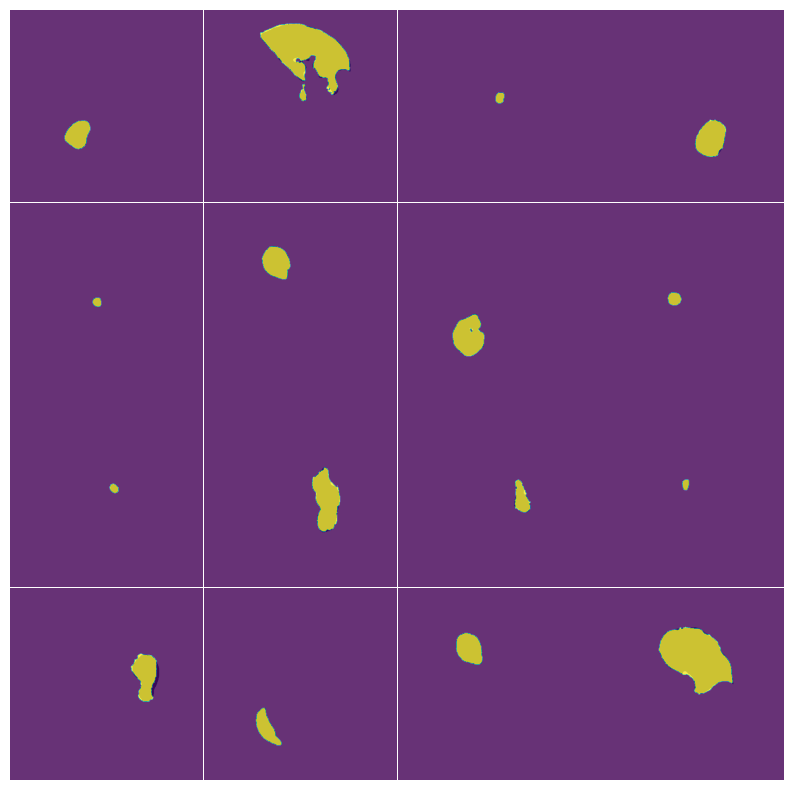

0.9480880942089338


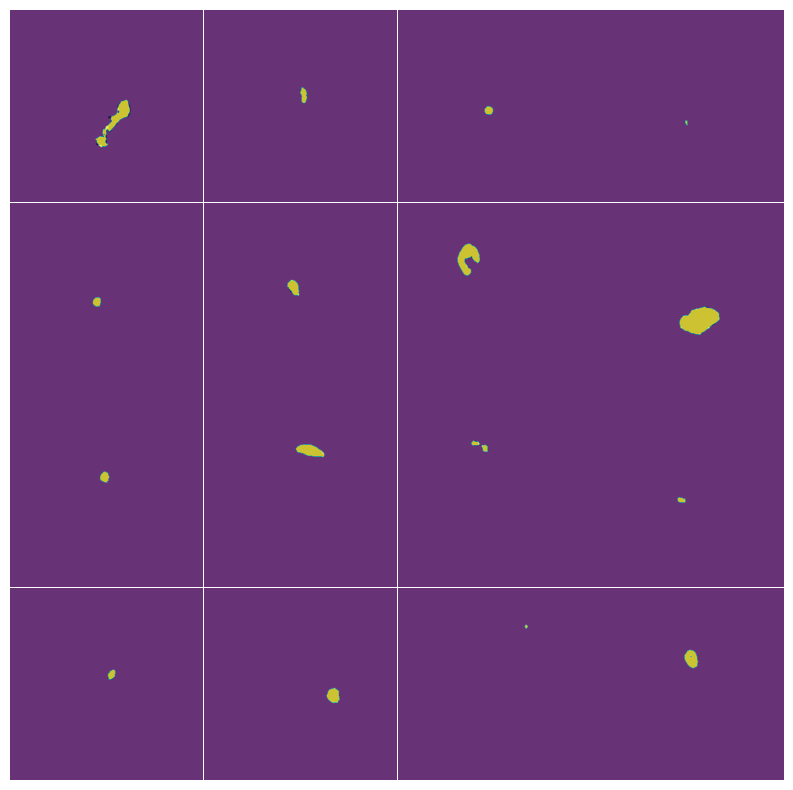

0.9210485736314572


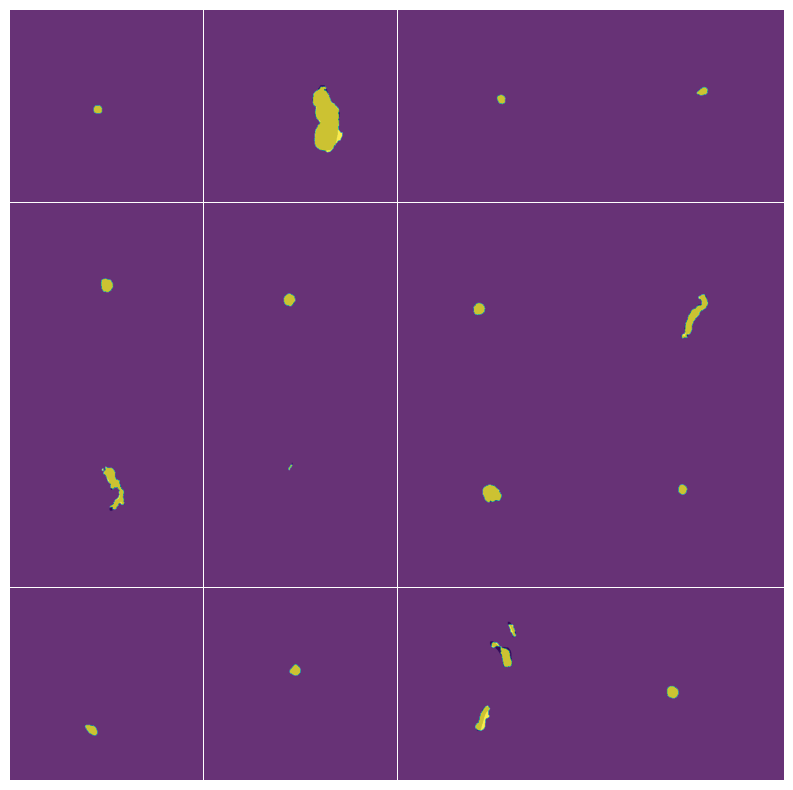

0.8810068649885584


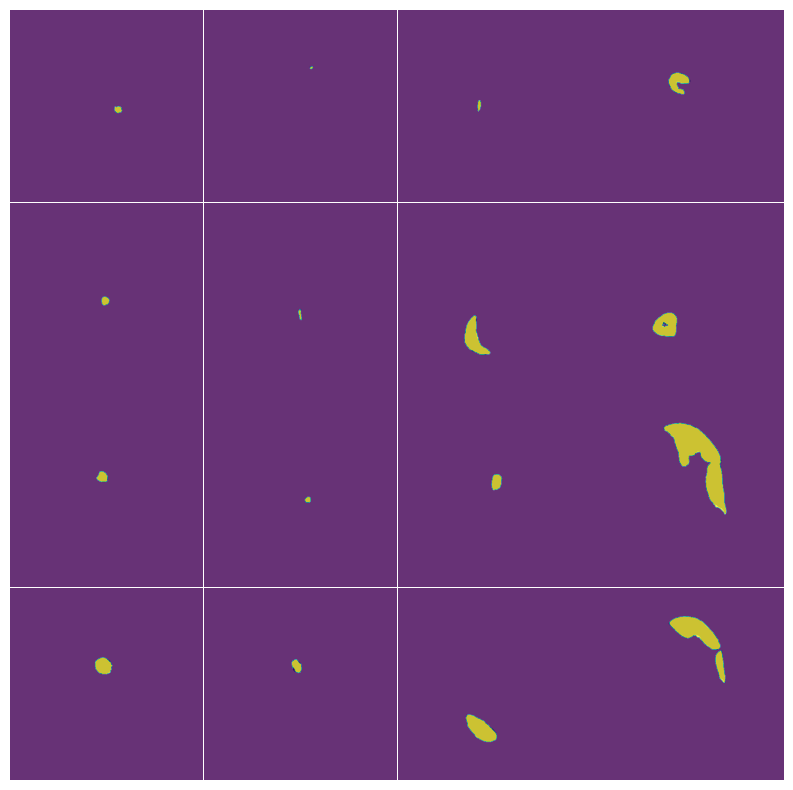

0.9540244654605263


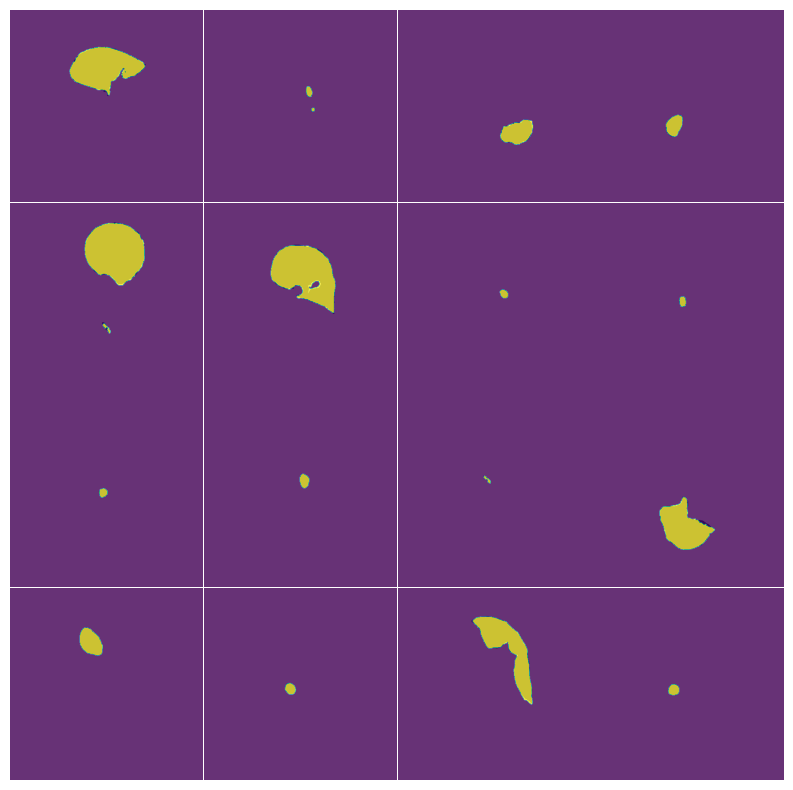

0.9601243492104471


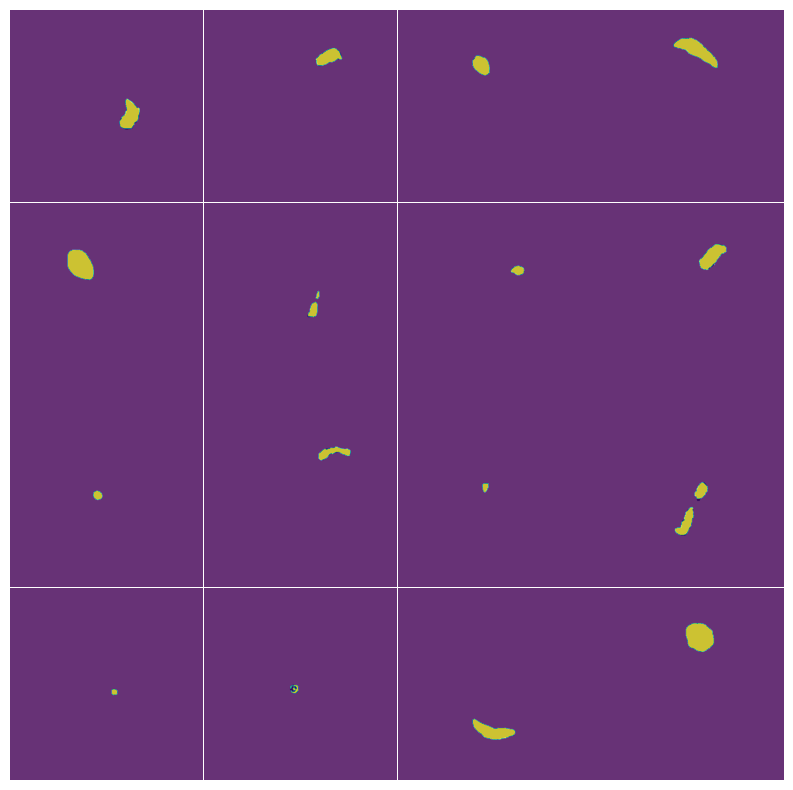

0.9347557967439566


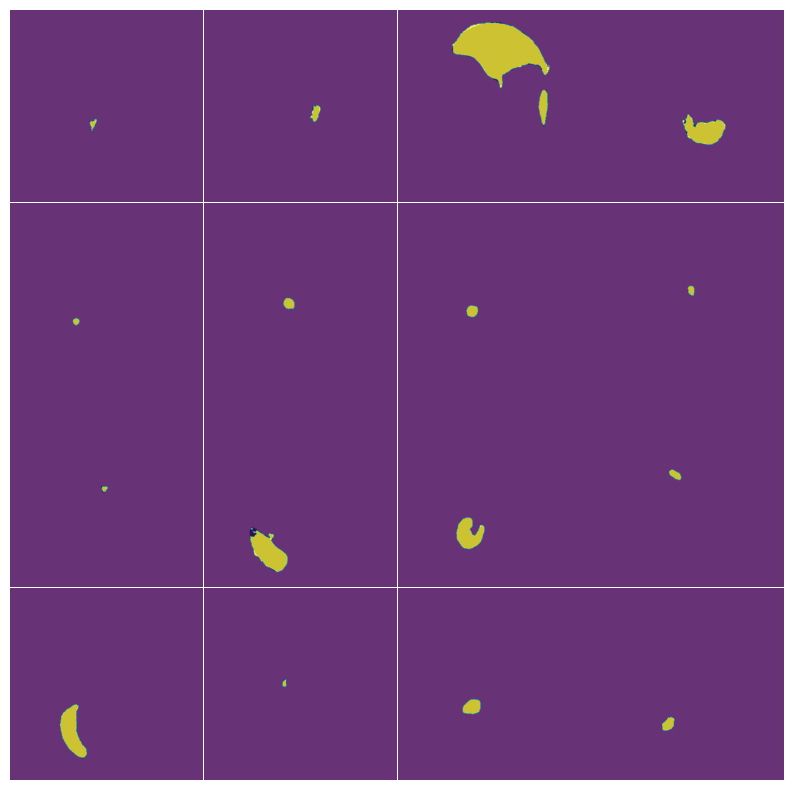

0.9459017932588489


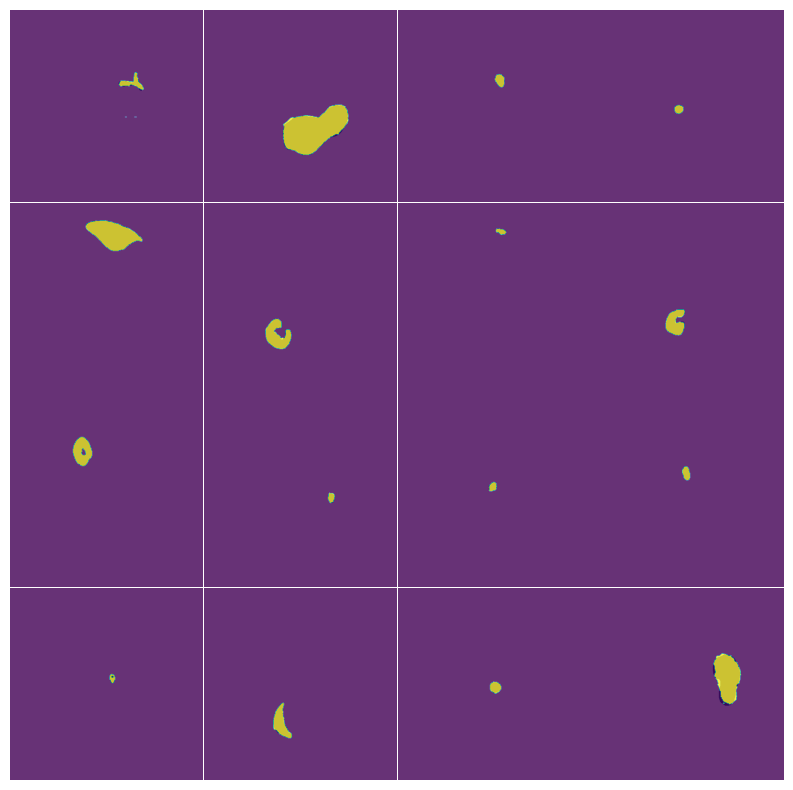

0.9381518959190481


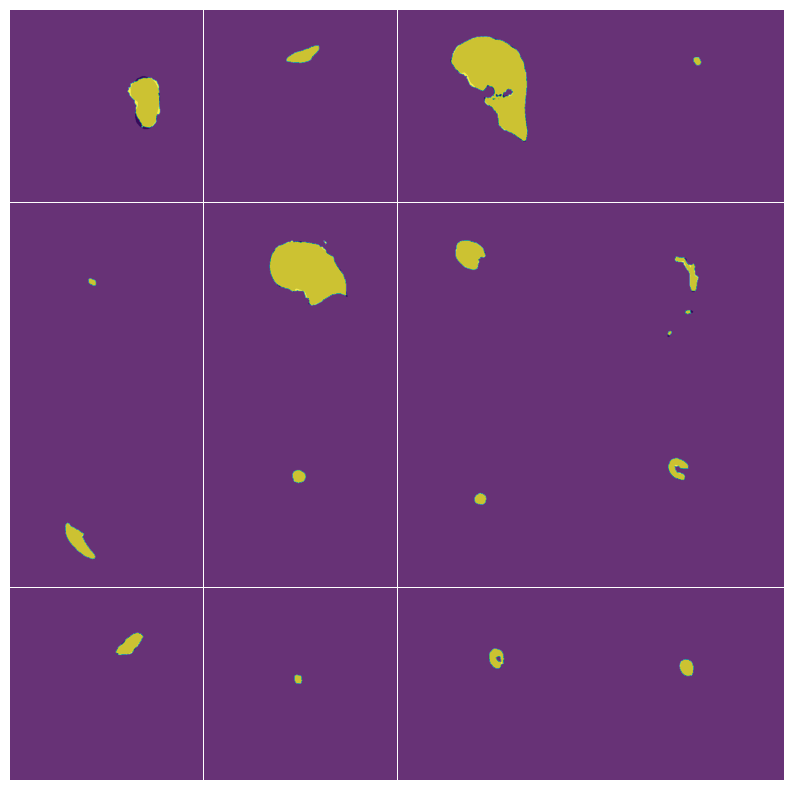

0.951058201058201


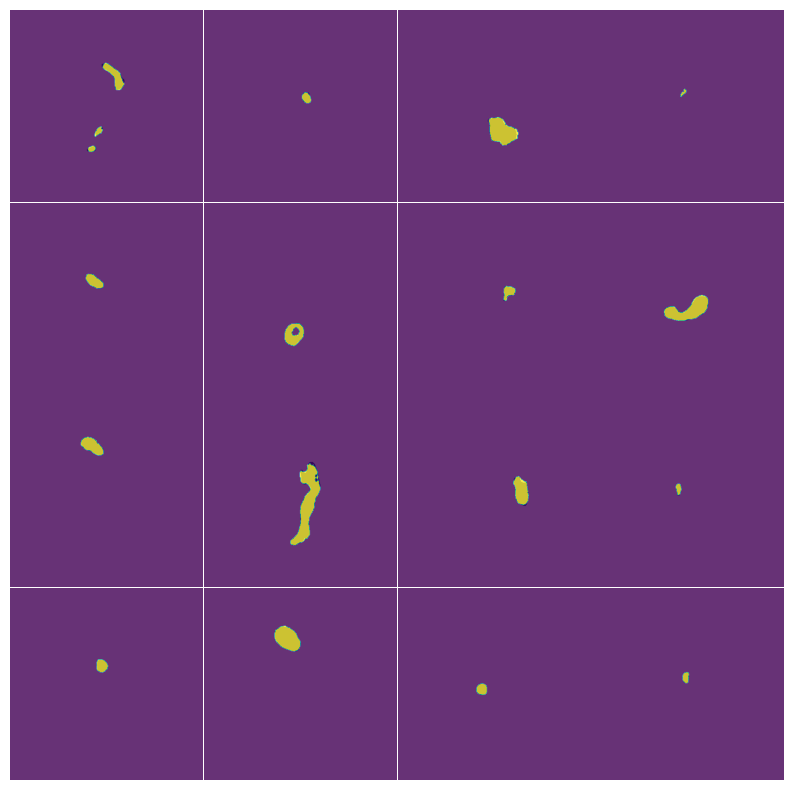

0.9208052858516611


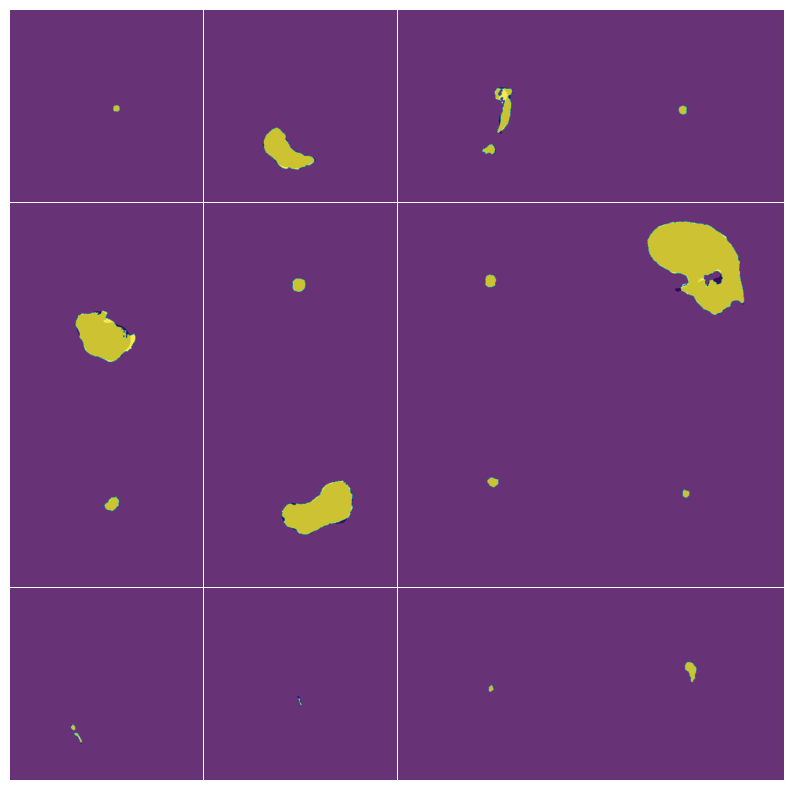

0.936370659932427


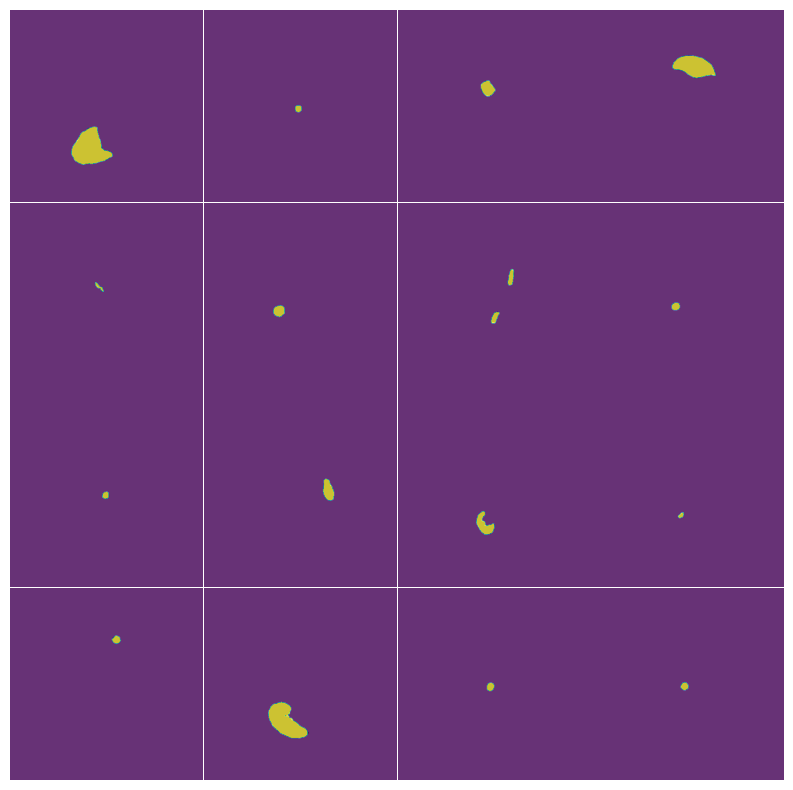

0.9517495250158328


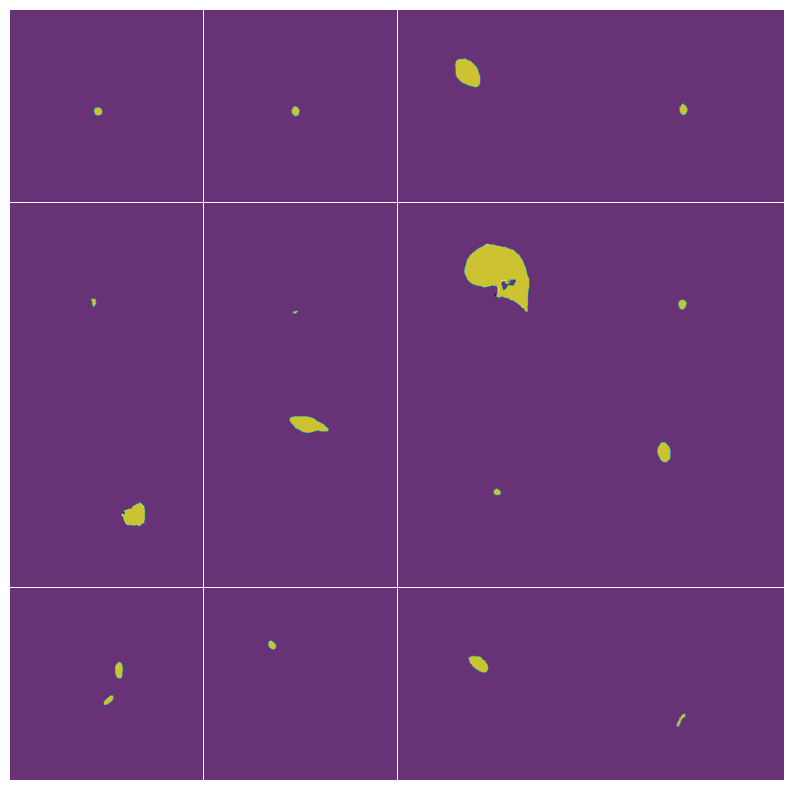

0.9553538815992807


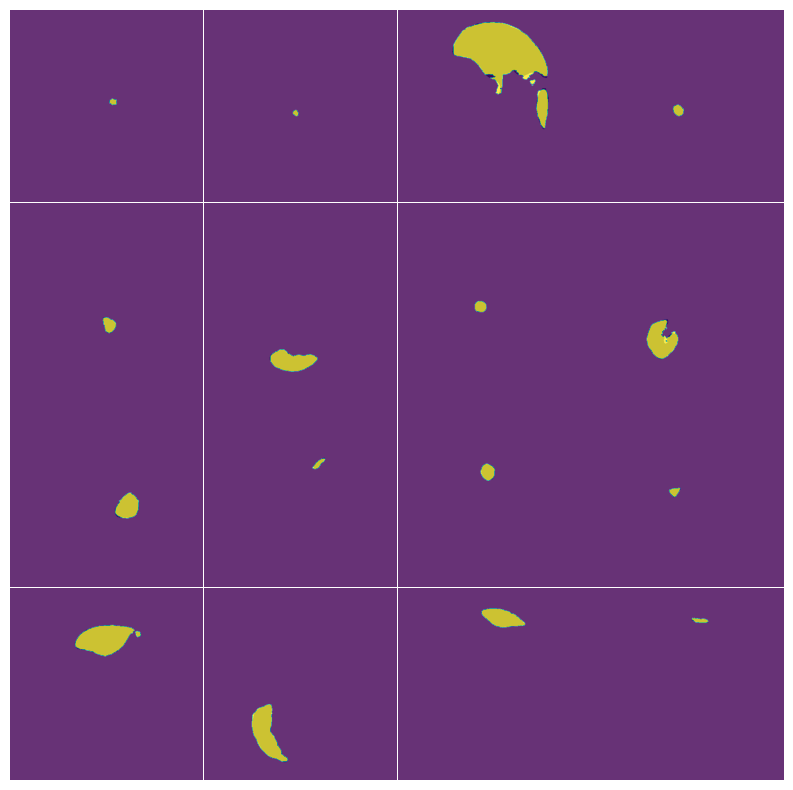

0.9469685880734213


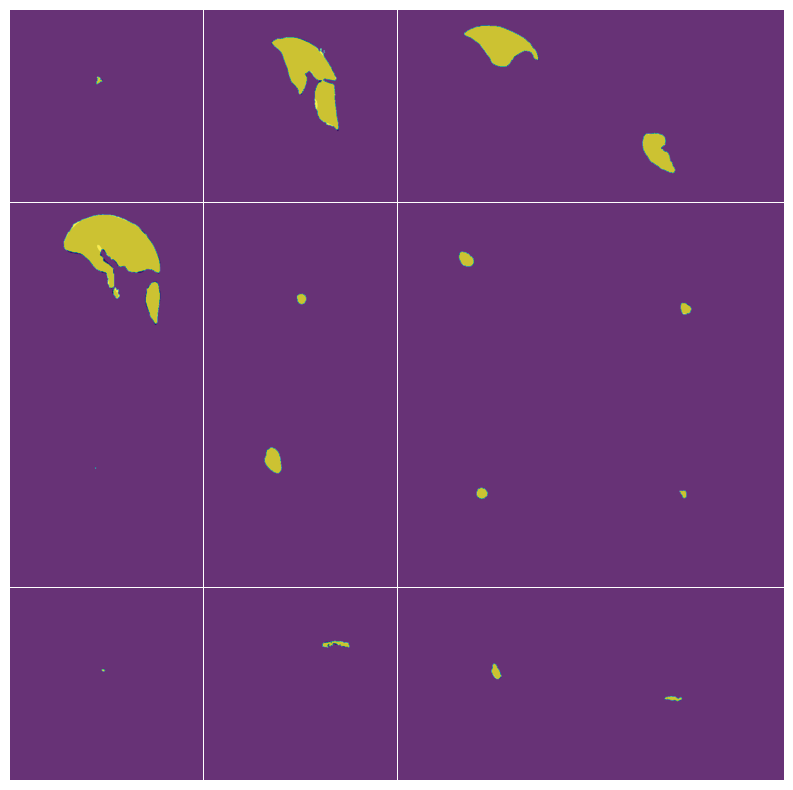

0.9526382280998844


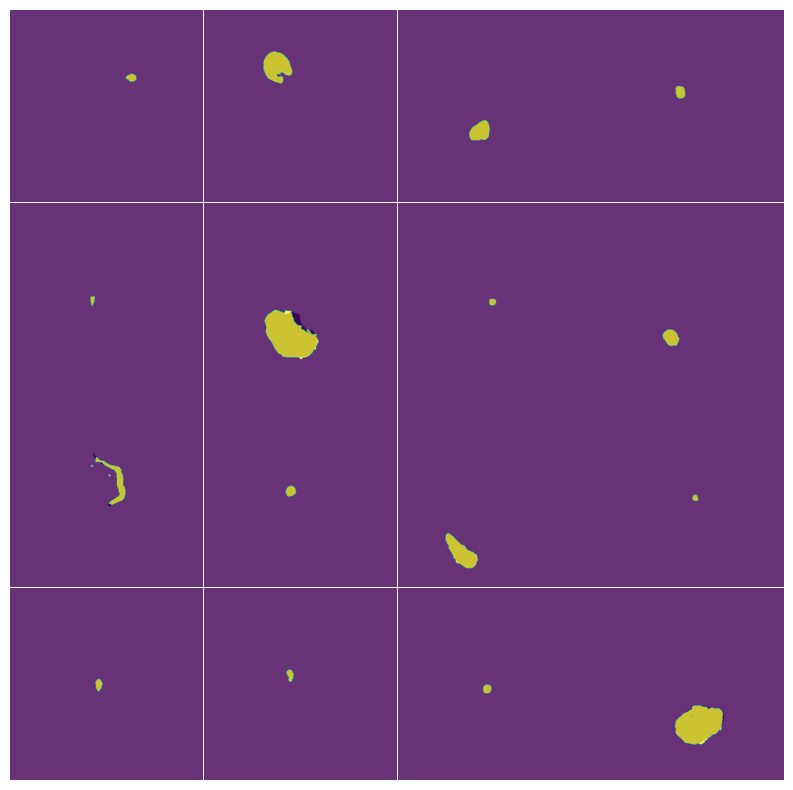

0.9283020680710014


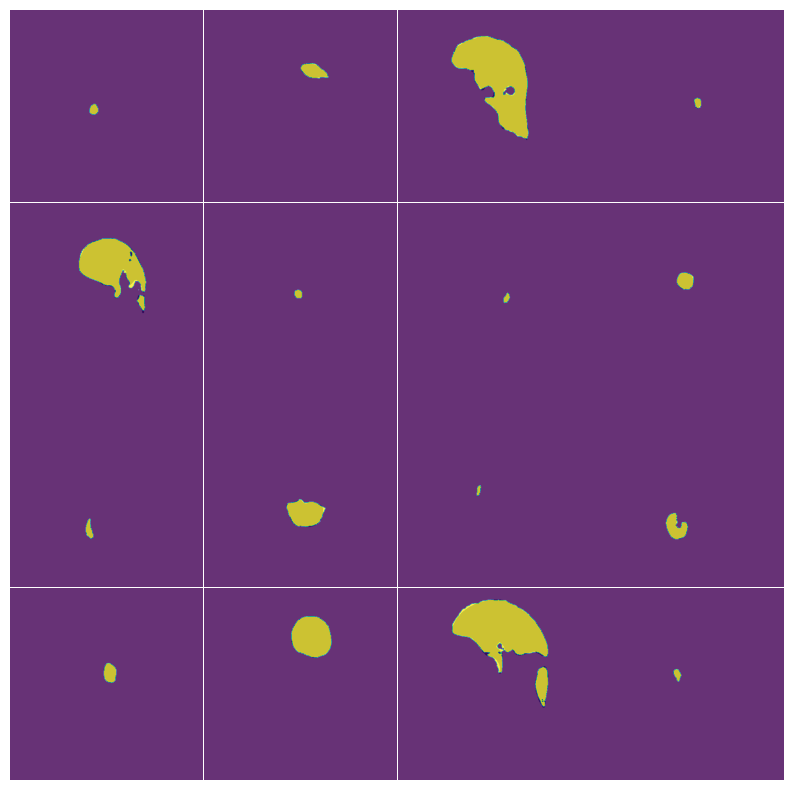

0.9570898048393648


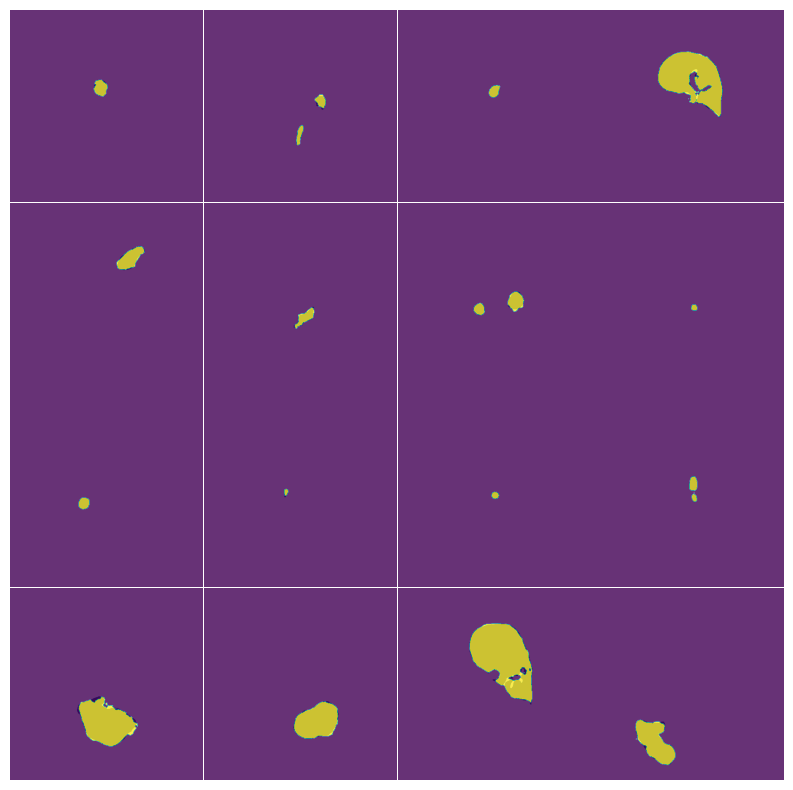

0.9358878983377441


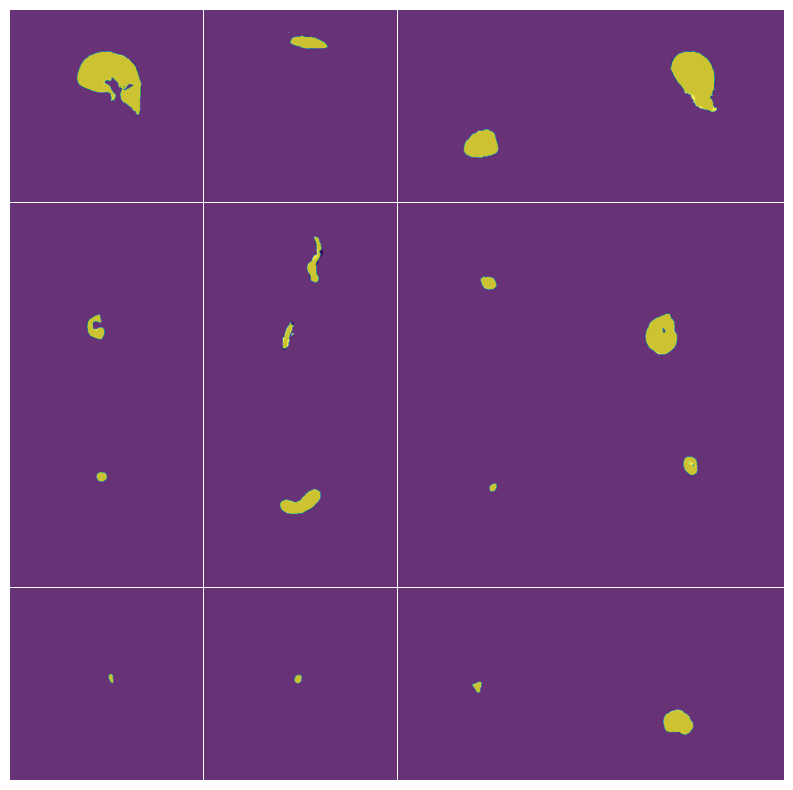

0.9396318618667535


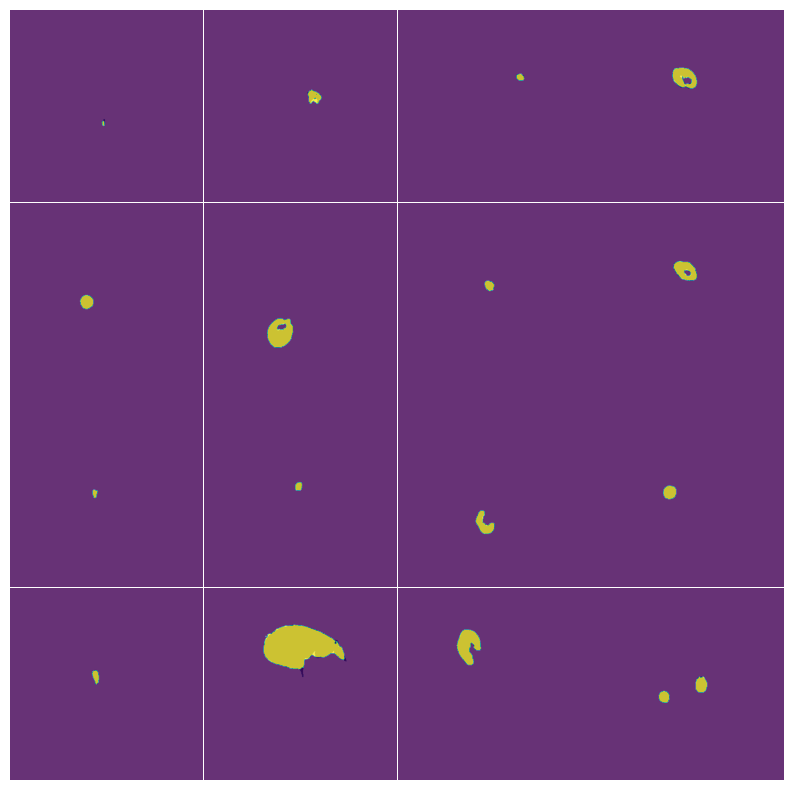

0.9444856643171339


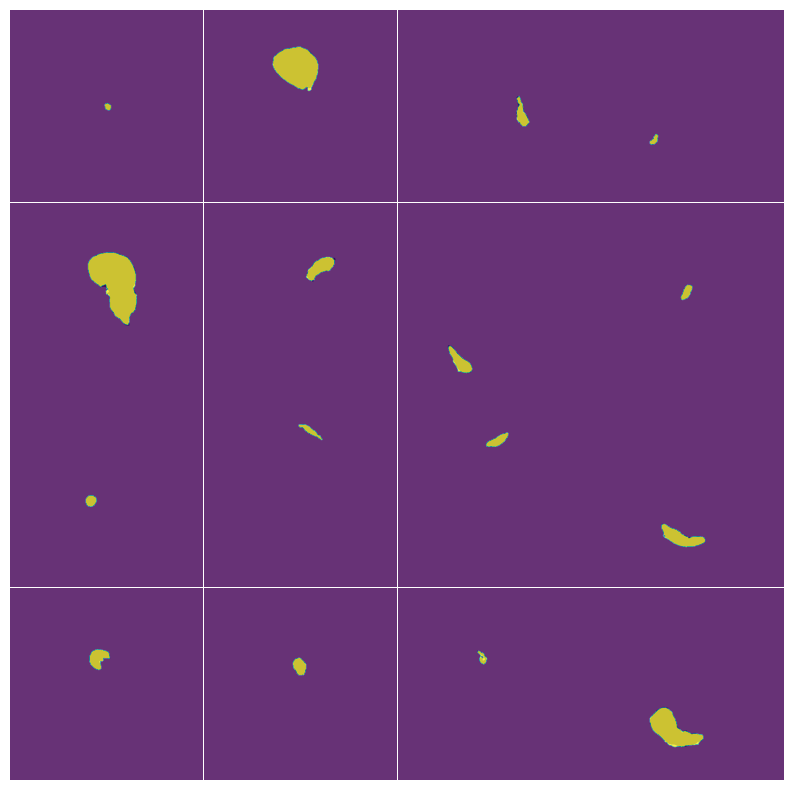

0.9504983650474728


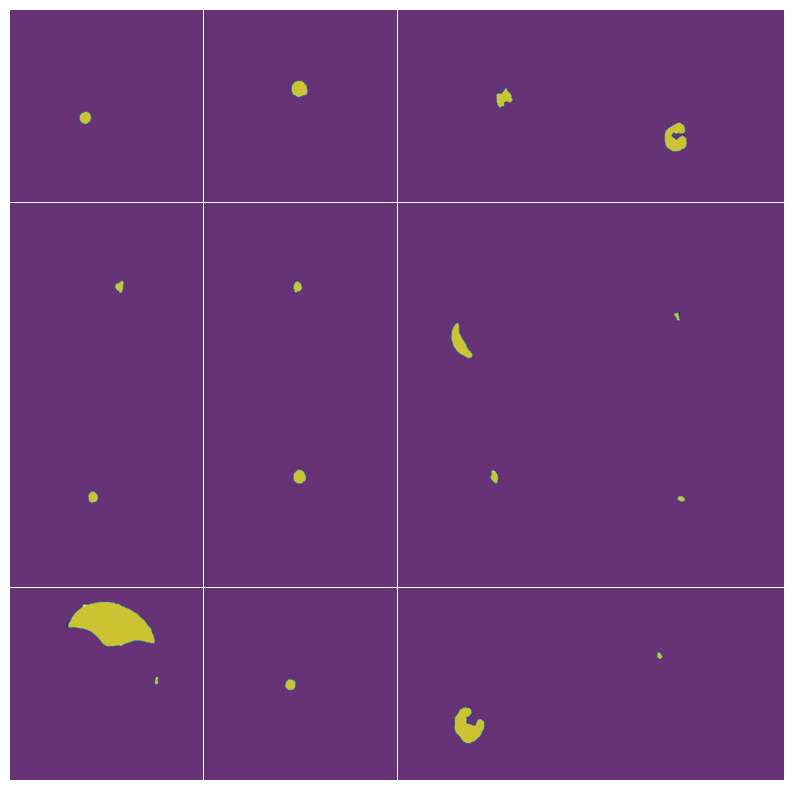

0.9578755093438246


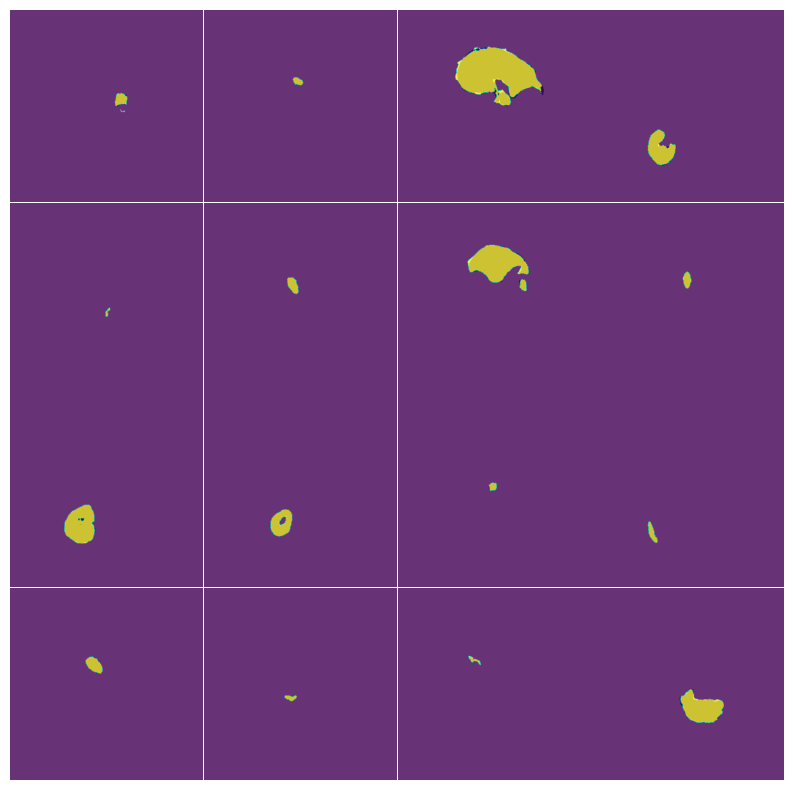

0.9357248371718256


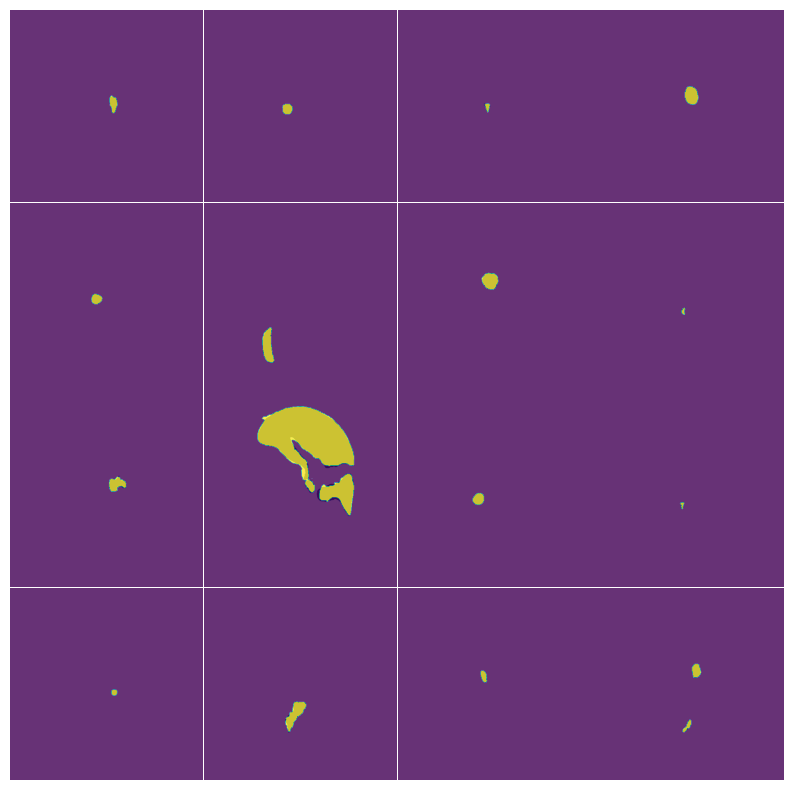

0.9345437071703159


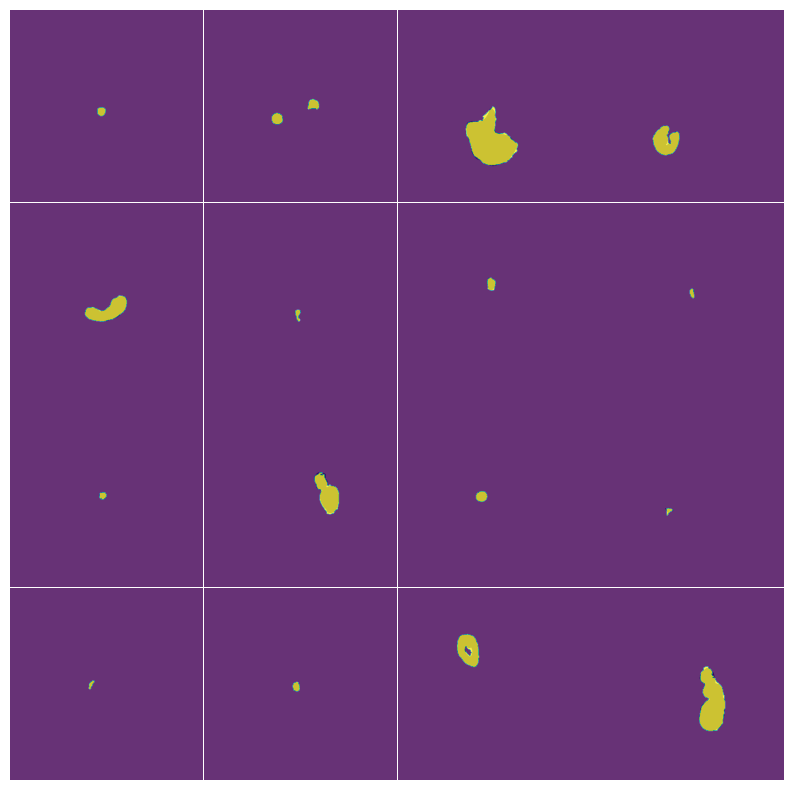

0.9370291674715086


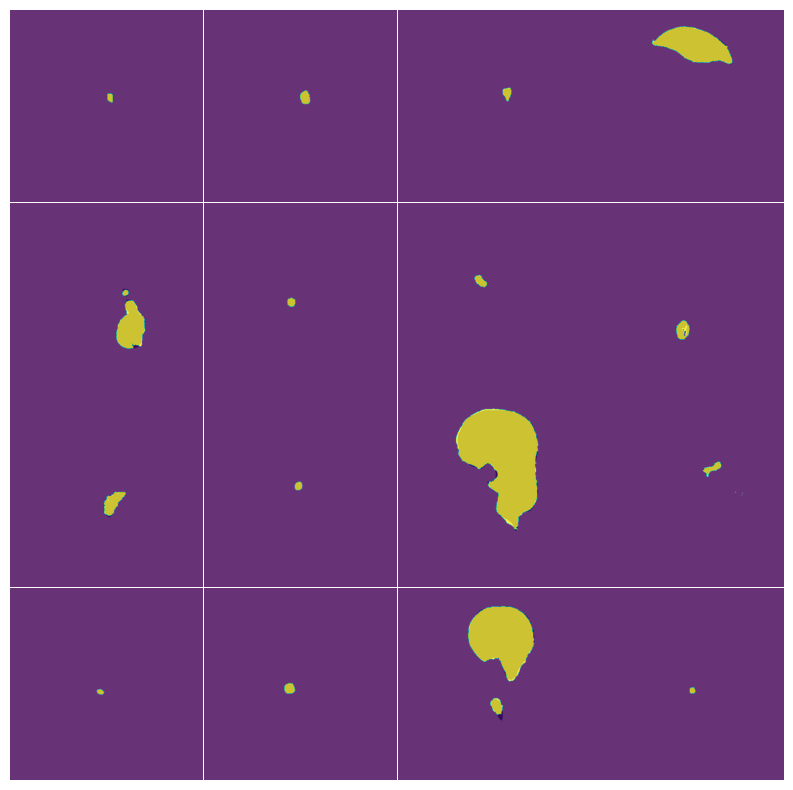

0.9575330596414499


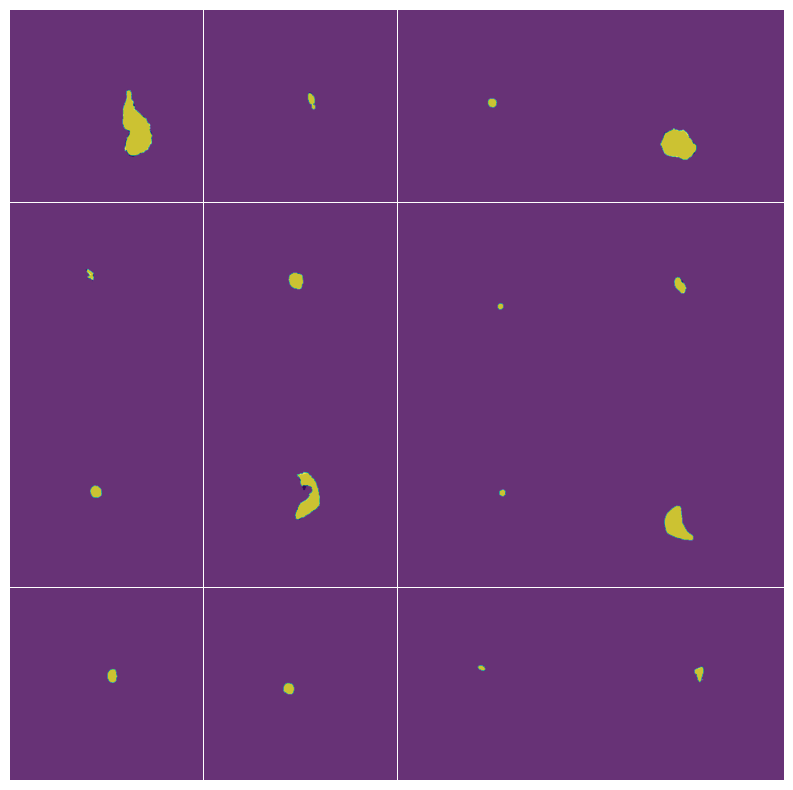

0.9408471857186743


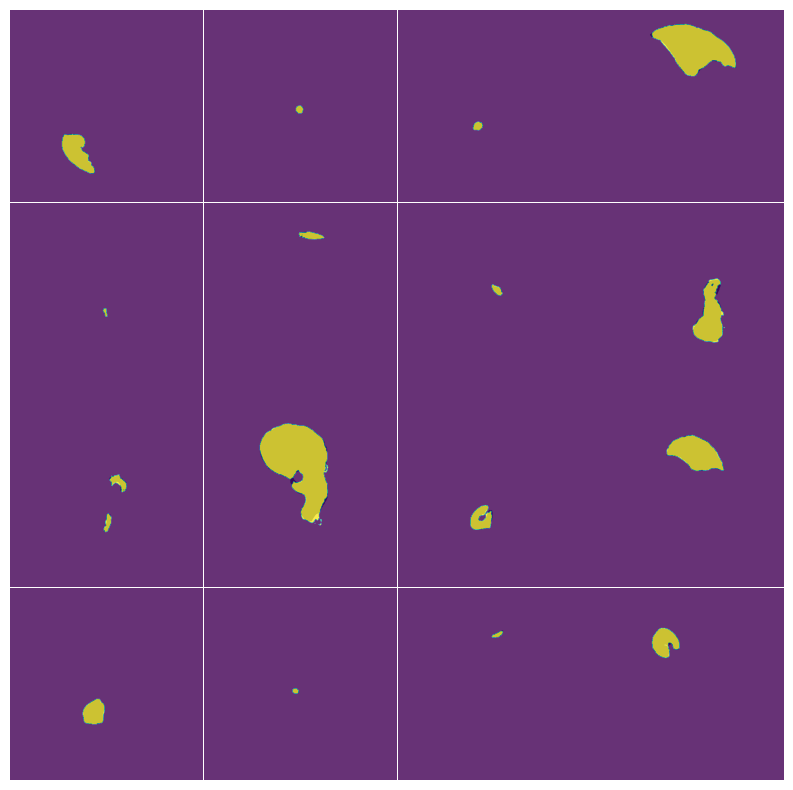

0.9506772266756403


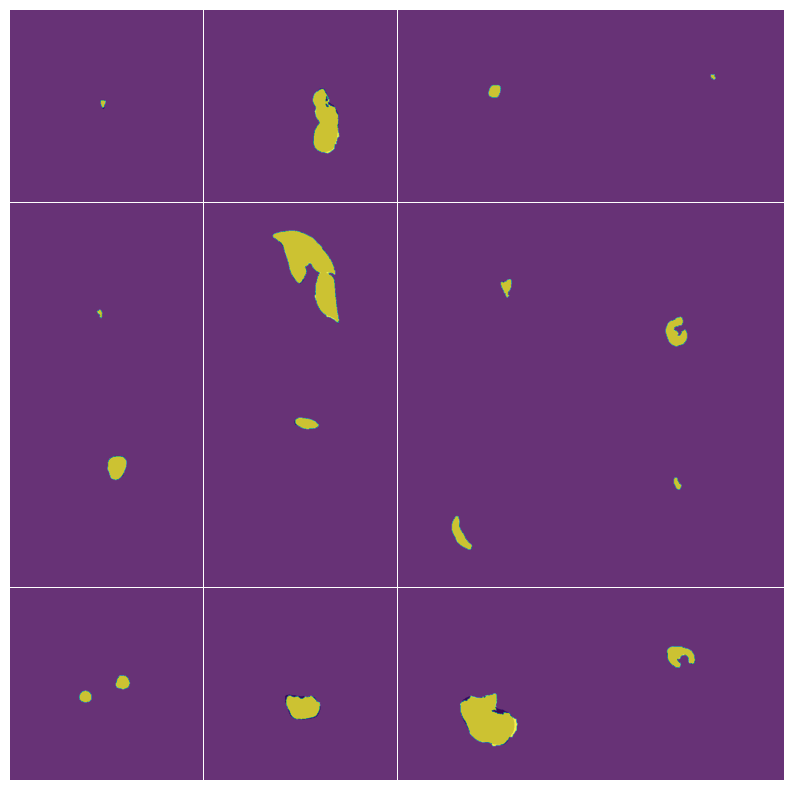

0.9368484395075382


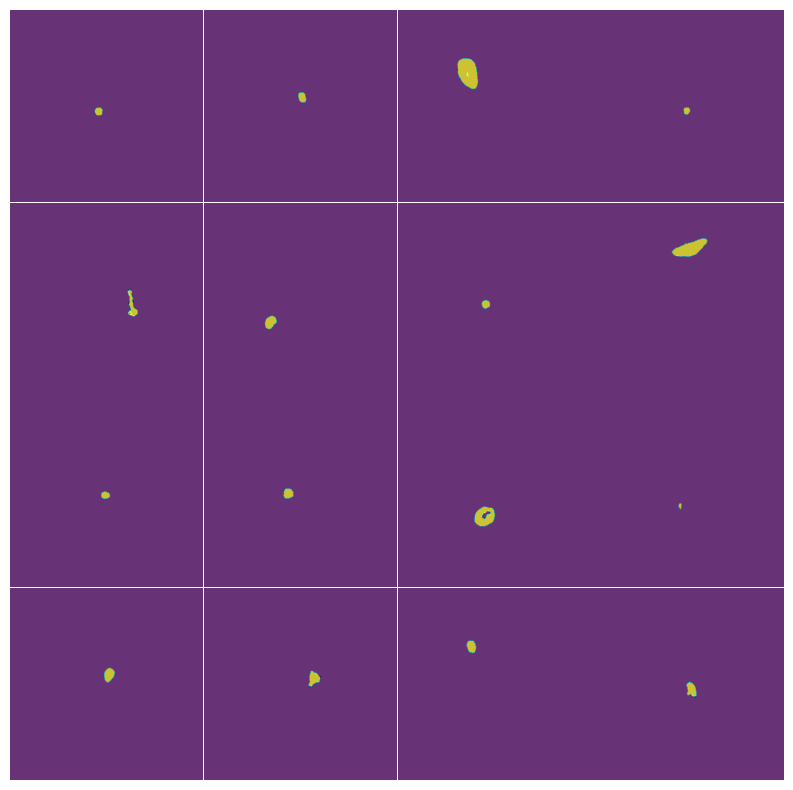

0.9322519705556641


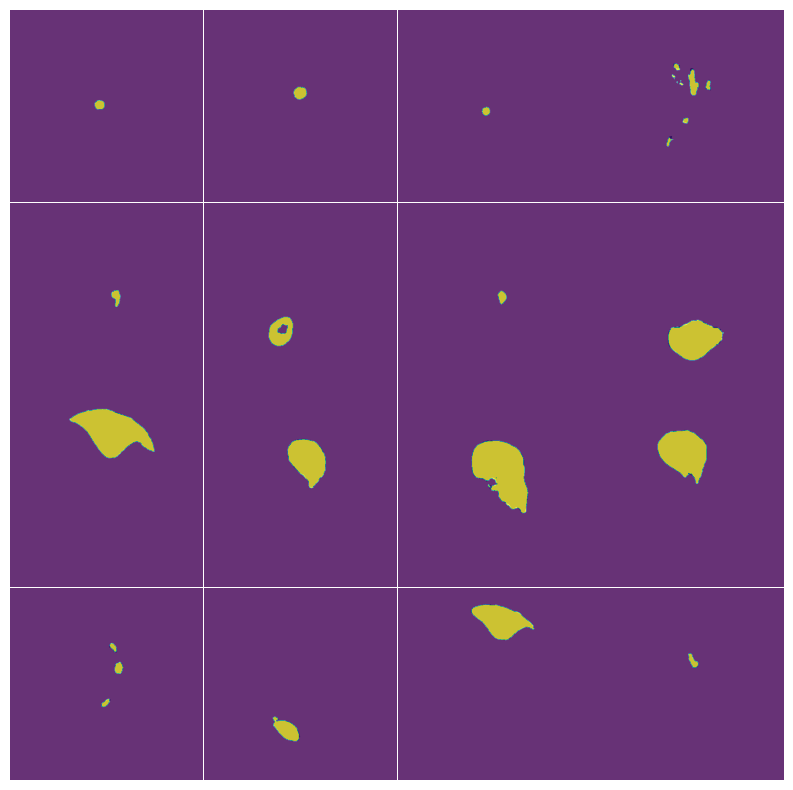

0.9619744550943905


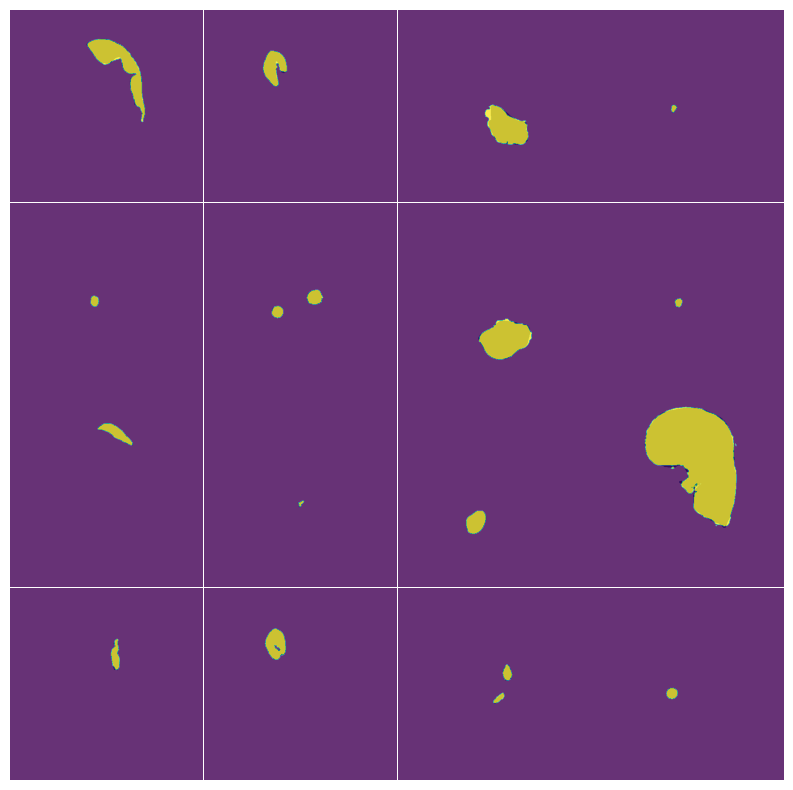

0.953327498391876


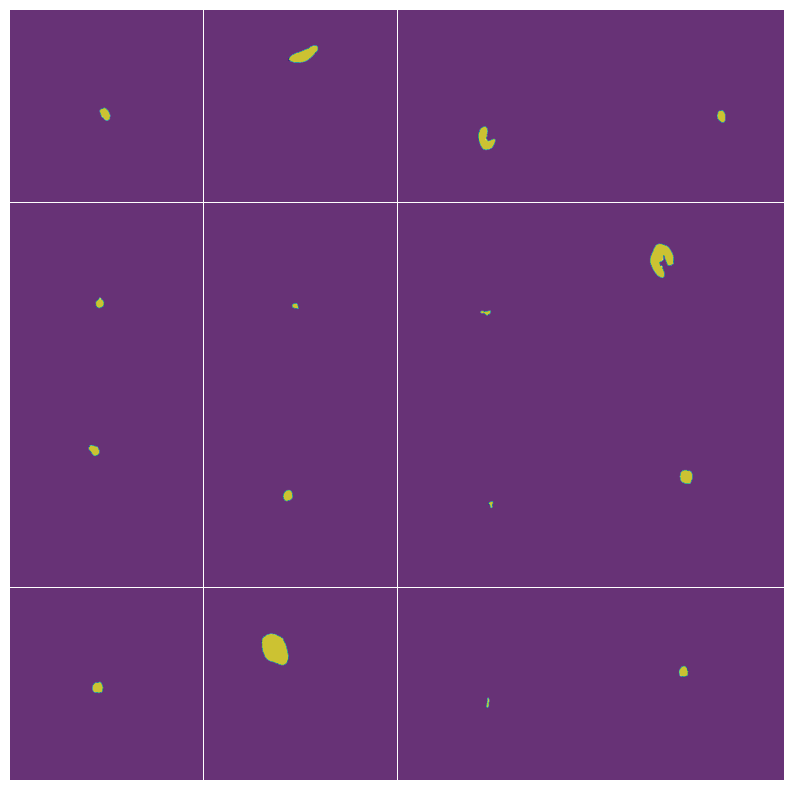

0.9458684456928839


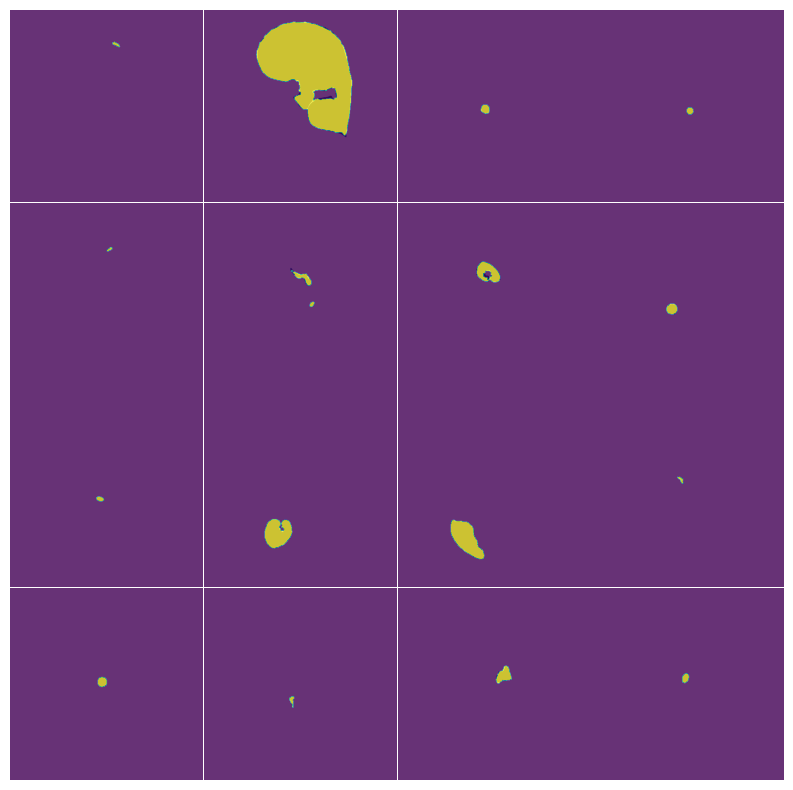

0.9586065066798615


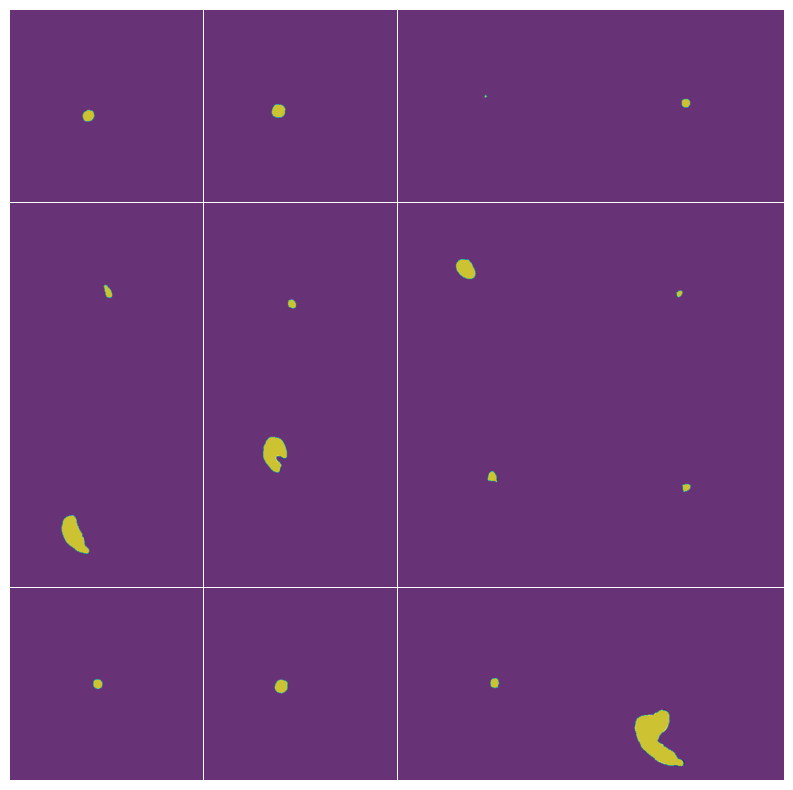

0.9606100546036528


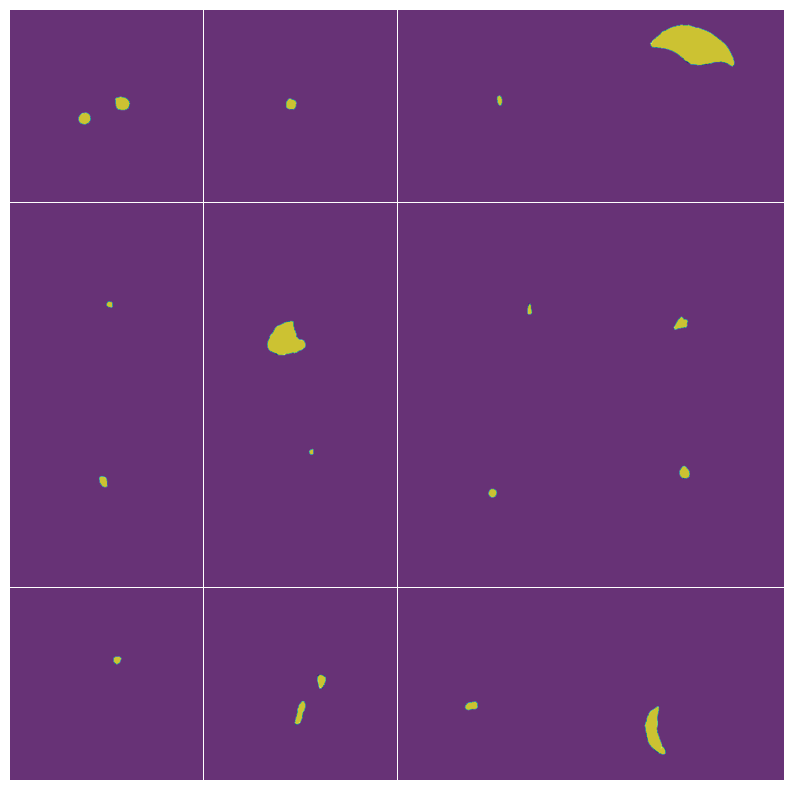

0.9589522586955193


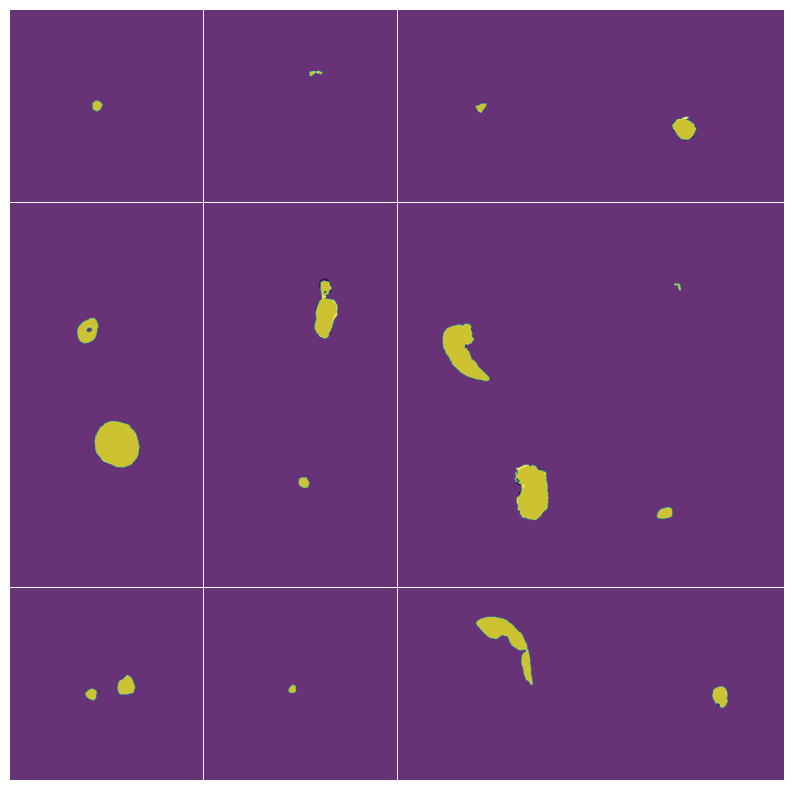

0.9406083688980328


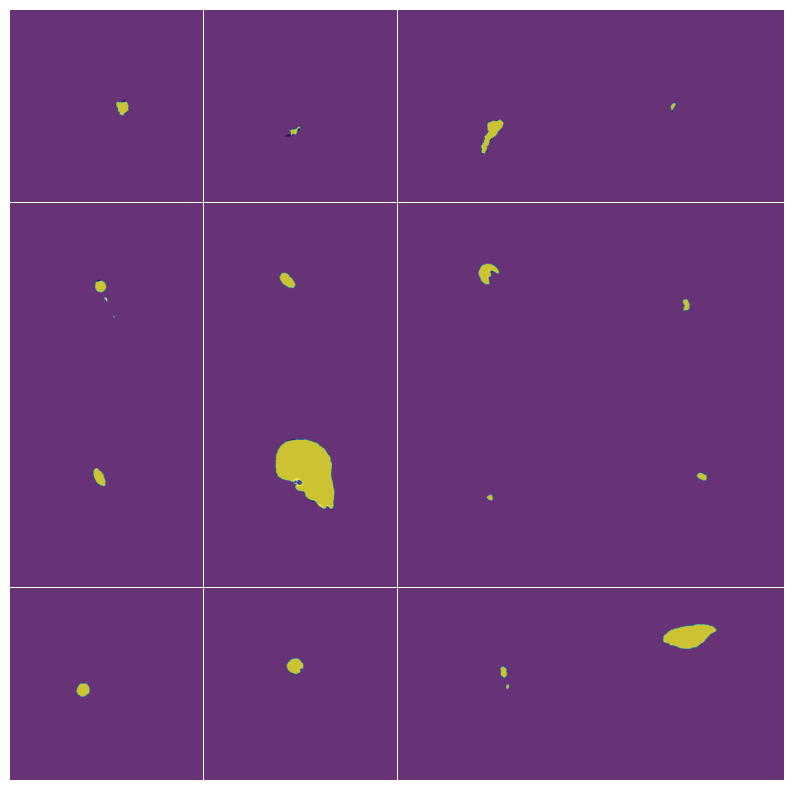

0.9458512085382442


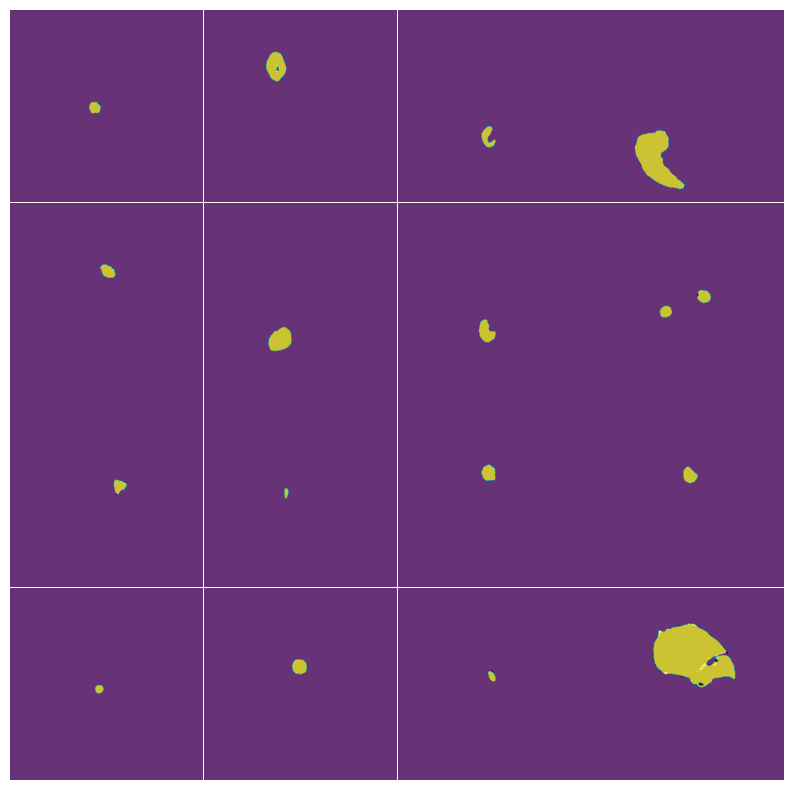

0.949805059047332


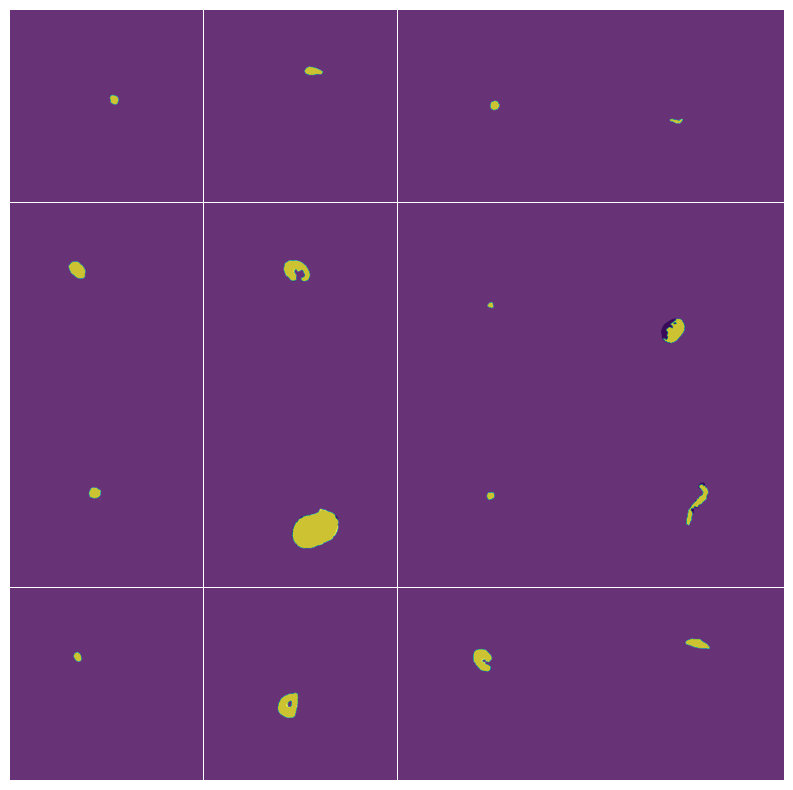

0.9066594672426206


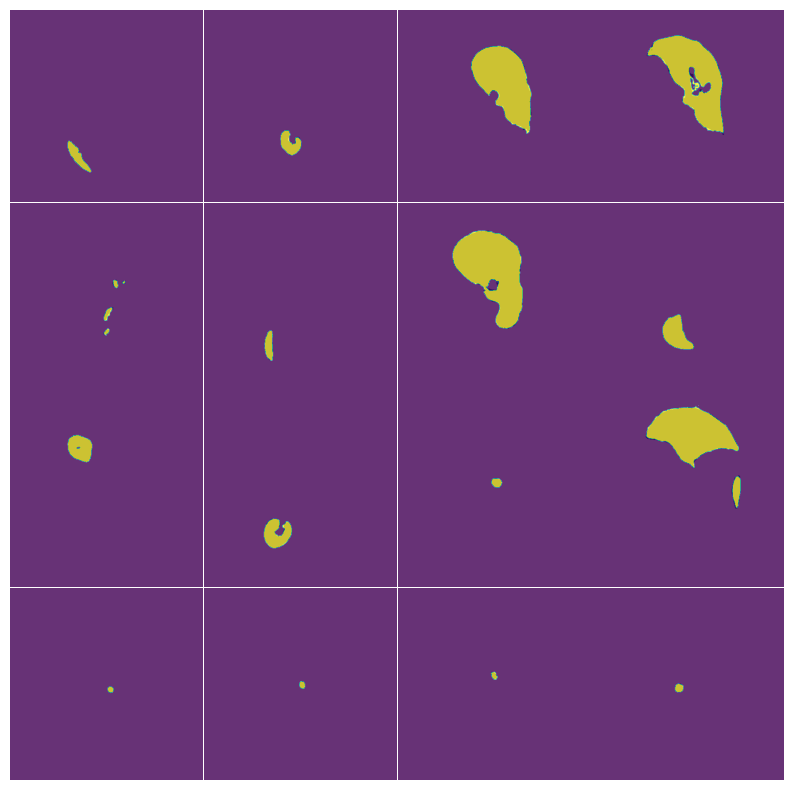

0.9621929101401484


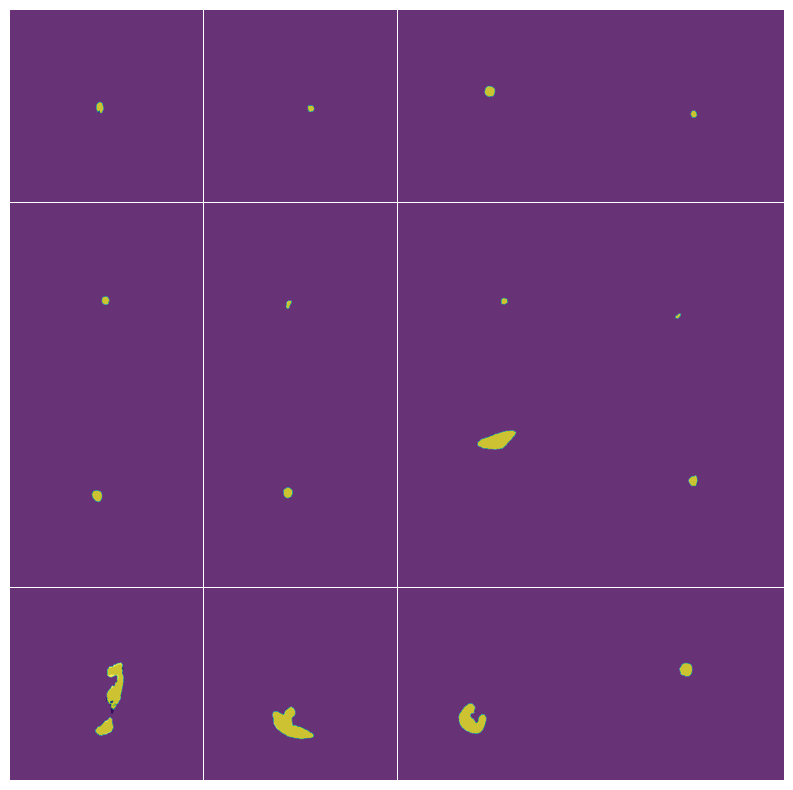

0.9257884972170687


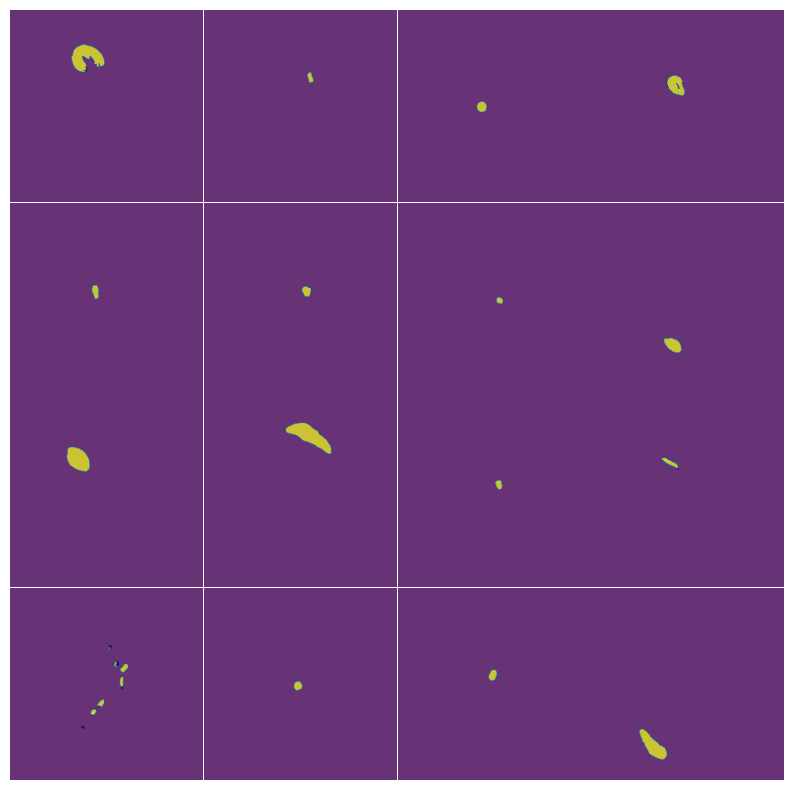

0.9271036727103673


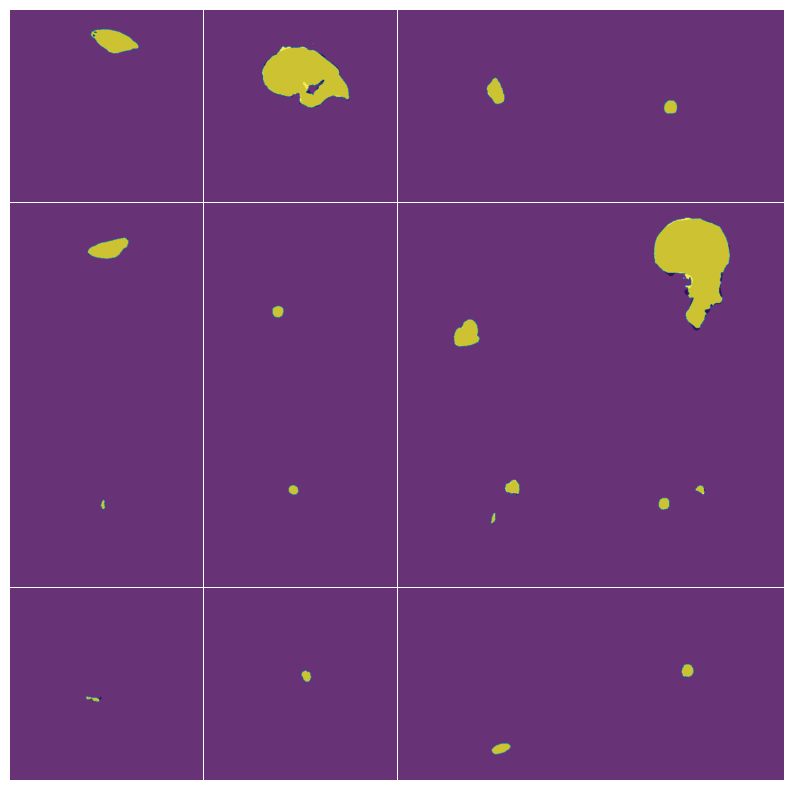

0.9482647306038421


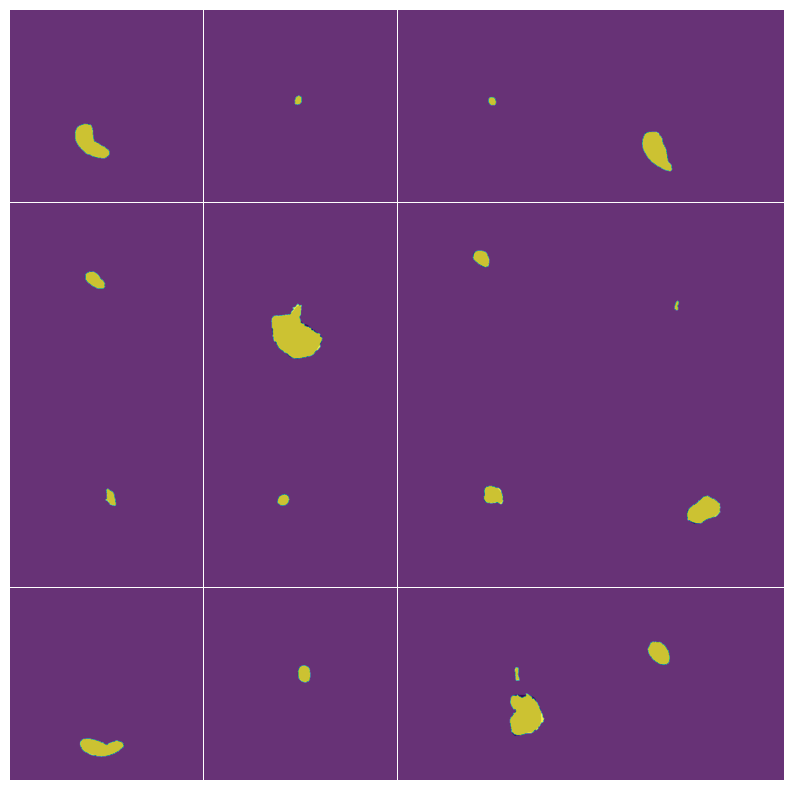

0.9527227368464103


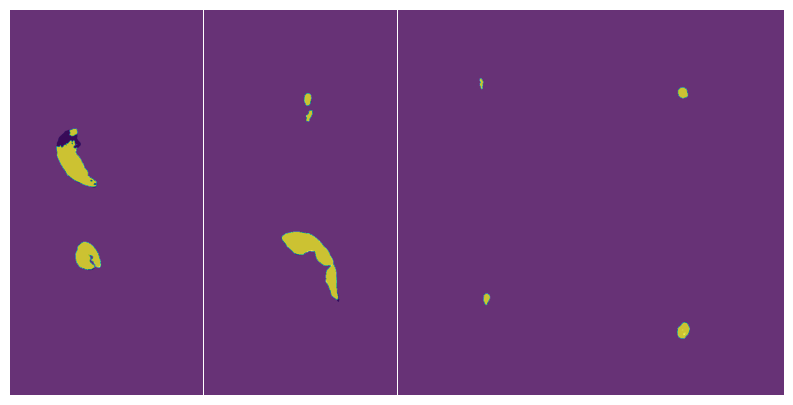

0.8793125838708281


In [26]:
visual_eval(val_dataloader, model, device, 15)

In [27]:
!cp /content/InterSegModelV1.pth /content/drive/MyDrive/InterSegModelV1.pth